In [143]:
import pandas as pd
import re
import string
import numpy as np

In [66]:
df = pd.read_csv('anime_reviews.csv', index_col = 0)

## Seperating the nlp data and the ratings

In [67]:
df_scores = df[['user','title','user_score']]
df_reviews = df[['user','title','user_review']]
#anime_rating = df_scores.pivot_table(index='user', columns='title', values='user_score')


# Building a Model on Surprise

In [130]:
from surprise import SVD, KNNBasic, KNNBaseline, CoClustering, SVDpp, NMF, BaselineOnly, SlopeOne
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

In [59]:
# Use the famous SVD algorithm.
svd = SVD()
knn_basic = KNNBasic()
knn_baseline = KNNBaseline()
co_cluster = CoClustering()
svdpp = SVDpp()
nmf = NMF()
baseline = BaselineOnly()
slopeone = SlopeOne()


models = [svd, knn_basic, knn_baseline, co_cluster, 
          svdpp, nmf, baseline, slopeone]

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(0, 10))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_scores[['user', 'title', 'user_score']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate

cross_validate(svd, data, cv=3)


{'test_rmse': array([1.8674308 , 1.85977938, 1.87979038]),
 'test_mae': array([1.42277668, 1.41152841, 1.42692395]),
 'fit_time': (2.49296498298645, 2.5430941581726074, 2.5661792755126953),
 'test_time': (0.1539597511291504, 0.14336109161376953, 0.13856983184814453)}

In [55]:
benchmark = []

for x in models:
    
    result = cross_validate(x, data, measures = ['RMSE'], cv=3, verbose = False)
    
    tmp = pd.DataFrame.from_dict(result).mean(axis=0)
    tmp = tmp.append(pd.Series([str(x).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


In [56]:
pd.DataFrame(benchmark).set_index('Algorithm')

test_rmse   fit_time  \
Algorithm                                                                  
<surprise.prediction_algorithms.matrix_factoriz...   1.871274   2.499261   
<surprise.prediction_algorithms.knns.KNNBasic o...   2.071752  26.700995   
<surprise.prediction_algorithms.knns.KNNBaselin...   1.946357  27.131028   
<surprise.prediction_algorithms.co_clustering.C...   1.999929   2.737695   
<surprise.prediction_algorithms.matrix_factoriz...   1.908686   7.734052   
<surprise.prediction_algorithms.matrix_factoriz...   2.669812   3.935093   
<surprise.prediction_algorithms.baseline_only.B...   1.865992   0.219581   
<surprise.prediction_algorithms.slope_one.Slope...   2.090636   0.254722   

                                                    test_time  
Algorithm                                                      
<surprise.prediction_algorithms.matrix_factoriz...   0.134504  
<surprise.prediction_algorithms.knns.KNNBasic o...   2.053803  
<surprise.prediction_algorithms.knns.KNNBaselin...   2.133729  
<surprise.prediction_algorithms.co_clustering.C...   0.107913  
<surprise.prediction_algorithms.matrix_factoriz...   0.359639  
<surprise.prediction_algorithms.matrix_factoriz...   0.121202  
<surprise.prediction_algorithms.baseline_only.B...   0.116741  
<surprise.prediction_algorithms.slope_one.Slope...   0.232789

In [49]:
param_grid = {'n_factors': [50, 100, 150, 200, 250, 300], 
              'n_epochs': [5, 10, 15, 20, 25, 30],
              'lr_all': [.0025, .005, .01, .025, .05],
              'reg_all': [.005, .01, .02, .05, .1]}

In [63]:
svd_gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5, n_jobs=-1)
svd_gs.fit(data)

In [64]:
print('RMSE:', round(svd_gs.best_score['rmse'], 4), 
      '; MAE:', round(svd_gs.best_score['mae'], 4))

RMSE: 1.8369 ; MAE: 1.3911


In [65]:
print('RMSE =', svd_gs.best_params['rmse'])

RMSE = {'n_factors': 200, 'n_epochs': 15, 'lr_all': 0.05, 'reg_all': 0.1}


## Attempting Train Test Splitb

In [66]:
trainset, testset = train_test_split(data, test_size=.25)

svd_best = SVD(n_factors = 200, n_epochs = 15, lr_all = .05, reg_all = .1)
# Train the algorithm on the trainset, and predict ratings for the testset
svd_best.fit(trainset)
predictions = svd_best.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.8325


1.8325237447393627

# Working with the NLP Data

## Cleaning the NLP data

In [68]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [44]:
stopwords_list = stopwords.words('english')
# lemmatizer = WordNetLemmatizer()

In [73]:
def review_cleaner(text):
    text = re.sub(r'.*Overall.*Enjoyment...', '', text, flags=re.DOTALL )
    text = re.sub(r'Helpful...read more.$', '', text, flags=re.DOTALL )
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub("\s+"," ", text)
    text = text.lower()
    return text

cleaner = lambda x: review_cleaner(x)

In [74]:
df_reviews.user_review = pd.DataFrame(df_reviews.user_review.apply(cleaner))

/Users/antoniohila/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Lemmatizing/Tokenizing Words

In [62]:
lemmatized_words = [lemmatizer.lemmatize(word) for words in tokenized_list for word in words]

In [80]:
tokenized_list = [word_tokenize(x) for x in df_reviews.user_review
                  if x not in stopwords_list]

In [86]:
df_reviews.user_review = [' '.join(x) for x in tokenized_list]

/Users/antoniohila/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [26]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(preprocessor = cleaner, ngram_range=(1, 1), min_df=0.0001, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df_reviews['user_review'])


TypeError: expected string or bytes-like object

In [14]:
pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf.get_feature_names(), index = df_reviews['user'])


aa  aaa  aaaaaand  aaaand  aaah  aaand  aah  aand  aaron  \
user                                                                          
tazillo           0.0  0.0       0.0     0.0   0.0    0.0  0.0   0.0    0.0   
Archaeon          0.0  0.0       0.0     0.0   0.0    0.0  0.0   0.0    0.0   
ChristopherKClaw  0.0  0.0       0.0     0.0   0.0    0.0  0.0   0.0    0.0   
literaturenerd    0.0  0.0       0.0     0.0   0.0    0.0  0.0   0.0    0.0   
M0nkeyD_Luffy     0.0  0.0       0.0     0.0   0.0    0.0  0.0   0.0    0.0   
...               ...  ...       ...     ...   ...    ...  ...   ...    ...   
ThatRandomDude    0.0  0.0       0.0     0.0   0.0    0.0  0.0   0.0    0.0   
Eagleshadow       0.0  0.0       0.0     0.0   0.0    0.0  0.0   0.0    0.0   
supercola123      0.0  0.0       0.0     0.0   0.0    0.0  0.0   0.0    0.0   
Temere            0.0  0.0       0.0     0.0   0.0    0.0  0.0   0.0    0.0   
Uncle             0.0  0.0       0.0     0.0   0.0    0.0  0.0   0.0    0.0   

                   ab  ...  ótima  ótimo  ótimos  última  último  últimos  \
user                   ...                                                  
tazillo           0.0  ...    0.0    0.0     0.0     0.0     0.0      0.0   
Archaeon          0.0  ...    0.0    0.0     0.0     0.0     0.0      0.0   
ChristopherKClaw  0.0  ...    0.0    0.0     0.0     0.0     0.0      0.0   
literaturenerd    0.0  ...    0.0    0.0     0.0     0.0     0.0      0.0   
M0nkeyD_Luffy     0.0  ...    0.0    0.0     0.0     0.0     0.0      0.0   
...               ...  ...    ...    ...     ...     ...     ...      ...   
ThatRandomDude    0.0  ...    0.0    0.0     0.0     0.0     0.0      0.0   
Eagleshadow       0.0  ...    0.0    0.0     0.0     0.0     0.0      0.0   
supercola123      0.0  ...    0.0    0.0     0.0     0.0     0.0      0.0   
Temere            0.0  ...    0.0    0.0     0.0     0.0     0.0      0.0   
Uncle             0.0  ...    0.0    0.0     0.0     0.0     0.0      0.0   

                  única  único   μs  ψnan  
user                                       
tazillo             0.0    0.0  0.0   0.0  
Archaeon            0.0    0.0  0.0   0.0  
ChristopherKClaw    0.0    0.0  0.0   0.0  
literaturenerd      0.0    0.0  0.0   0.0  
M0nkeyD_Luffy       0.0    0.0  0.0   0.0  
...                 ...    ...  ...   ...  
ThatRandomDude      0.0    0.0  0.0   0.0  
Eagleshadow         0.0    0.0  0.0   0.0  
supercola123        0.0    0.0  0.0   0.0  
Temere              0.0    0.0  0.0   0.0  
Uncle               0.0    0.0  0.0   0.0  

[72056 rows x 34938 columns]

In [ ]:
# pairwise_similarity = tfidf_matrix * tfidf_matrix.T 

## Textblob

In [70]:
from textblob import TextBlob

In [113]:
sentiment_score = []

In [114]:
for x in df_reviews.user_review:
    text = x
    blob = TextBlob(text)
    if len(x) <= 5:
        sentiment_score.append(0)
    else:
        for sentence in blob.sentences:
            sentiment_score.append(sentence.sentiment.polarity)

In [119]:
sentiment_df = pd.DataFrame(sentiment_score, columns = ['Sentiment_score'])

## Using SpaCy

In [ ]:
df_review

## Creating a recommendation system using sentiment score

In [123]:
df_review_score = pd.concat([df_reviews, sentiment_df], axis = 1)

'because this is one mecha anime that proved to me that not all mecha anime are boring'

In [126]:
df_all_scores = pd.concat([df_scores, sentiment_df], axis = 1)

In [129]:
df_all_scores['final_score'] = [df_all_scores.user_score[i] * df_all_scores.Sentiment_score[i] 
                               for i in range(len(df_all_scores.user_score))]


In [144]:
df_all_scores['abs_score'] = np.abs(df_all_scores['final_score'])

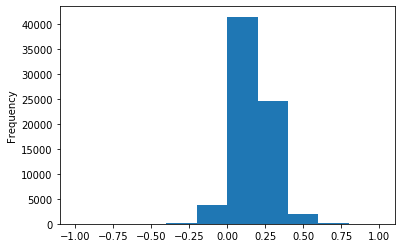

In [159]:
df_all_scores['Sentiment_score'].plot.hist()

In [163]:
svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)


reader = Reader(rating_scale=(0, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_all_scores[['user', 'title', 'abs_score']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate

cross_validate(svd, data, cv=3)

{'test_rmse': array([0.96797249, 0.95576238, 0.94726112]),
 'test_mae': array([0.74245453, 0.73153386, 0.73374903]),
 'fit_time': (3.1787030696868896, 3.3639962673187256, 3.3210690021514893),
 'test_time': (0.13550400733947754, 0.15555500984191895, 0.1517031192779541)}

In [162]:
svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)


reader = Reader(rating_scale=(-.5, .75))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df_all_scores[['user', 'title', 'Sentiment_score']], reader)

# We can now use this dataset as we please, e.g. calling cross_validate

cross_validate(svd, data, cv=3)

{'test_rmse': array([0.11478907, 0.11368811, 0.11426134]),
 'test_mae': array([0.0851366 , 0.0841176 , 0.08489617]),
 'fit_time': (3.204177141189575, 3.367434024810791, 4.017949819564819),
 'test_time': (0.1531510353088379, 0.14189839363098145, 0.1963329315185547)}

## Modeling using lightfm

In [156]:
from lightfm import LightFM
from lightfm import cross_validation

In [150]:
model = LightFM()

In [153]:
data = df_all_scores[['user', 'title', 'user_score', 'Sentiment_score']]

In [158]:
cross_validation.random_train_test_split(data)

ValueError: Interactions must be a scipy.sparse matrix.

# Zawar Code

In [167]:
from collections import defaultdict
from surprise import Dataset
from surprise import SVD

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(0, 10))

data = Dataset.load_from_df(df_scores[['user', 'title', 'user_score']], reader)
trainset = data.build_full_trainset()

svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)

svd.fit(trainset)
# Than predict ratings for all pairs (u, i) that are NOT in the training set.


testset = trainset.build_anti_testset()

predictions = svd.test(testset)

top_n_baseline = get_top_n(predictions, n=3)


# Print the recommended items for each user
for uid, user_ratings in top_n_baseline.items():
    print(uid, [iid for (iid, _) in user_ratings])

tazillo ['Gintama Season 4', 'Owarimonogatari Second Season', 'Descending Stories: Showa Genroku Rakugo Shinju']
Archaeon ['Gintama Season 4', 'Gintama Season 2', "Natsume's Book of Friends Season 6"]
ChristopherKClaw ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Berserk']
literaturenerd ['Aria the Origination', 'Maison Ikkoku', 'Gintama Season 2']
M0nkeyD_Luffy ['Aria the Natural', 'Gintama Season 4', 'Owarimonogatari Second Season']
bakababe ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Space Brothers']
ryuu_zer0 ["Natsume's Book of Friends Season 6", 'Steins;Gate', 'Gintama Season 4']
Reimei-Chan ['Owarimonogatari Second Season', 'Fighting Spirit', "Natsume's Book of Friends Season 6"]
Rurouni_Tidus ["Natsume's Book of Friends Season 6", 'Fighting Spirit', 'Owarimonogatari Second Season']
Malighos ['Fighting Spirit', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
bananapotato ['Owarimonogatari Second Season', "Natsume's Book of Friends Season 6

aoikimahri ['Tanoshii Muumin Ikka', 'Cowboy Bebop', "Natsume's Book of Friends Season 6"]
Bjobbel ['Fighting Spirit', 'Gintama Season 2', 'Gintama Season 4']
DNGlist ['Gintama Season 4', 'Owarimonogatari Second Season', 'Space Brothers']
hentaifreeak ['Clannad ~After Story~', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
ElPsyK0ngroo ['Gintama Season 4', 'Gintama Season 2', 'Owarimonogatari Second Season']
HappyNewb ['Gintama', "Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season']
Vicuro ['Fullmetal Alchemist: Brotherhood', 'Fighting Spirit', "Natsume's Book of Friends Season 6"]
sg001 ['Gintama Season 4', 'Owarimonogatari Second Season', 'Fighting Spirit']
Ethan_07 ['Assassination Classroom Second Season', "Natsume's Book of Friends Season 6", 'Gintama Season 4']
Uthantthinknot ['Gintama Season 2', 'Fighting Spirit', 'Gintama Season 4']
TuxTicWeeb ['Gintama Season 4', 'Owarimonogatari Second Season', 'Gintama']
ShuyaWatanabe ['Fighting Spirit', 'Gintama Se

joegonzalez722 ['Owarimonogatari Second Season', 'Assassination Classroom Second Season', "Natsume's Book of Friends Season 6"]
TheOldRikuK ['Gintama Season 4', 'Owarimonogatari Second Season', 'Fighting Spirit']
zuttzek66 ['Fullmetal Alchemist: Brotherhood', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
BowlingJD ['Fullmetal Alchemist: Brotherhood', 'anohana: The Flower We Saw That Day', 'Showa Genroku Rakugo Shinju']
vittumainen ['Gintama Season 4', 'Takarajima', "Natsume's Book of Friends Season 6"]
kittycats468 ['Gintama Season 4', 'Showa Genroku Rakugo Shinju', 'Fighting Spirit']
anku9998 ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
SMikotoRayearth ['Owarimonogatari Second Season', "Natsume's Book of Friends Season 6", 'Fullmetal Alchemist: Brotherhood']
Ztreg ['Gintama Season 4', 'The Rose of Versailles', 'Fullmetal Alchemist: Brotherhood']
BonyaNya ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Steins;Gate']

Lord_Dracule ['Gintama Season 2', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
MdotO ['Gintama Season 4', 'Future Boy Conan', "Natsume's Book of Friends Season 6"]
my_wander_woman ["Natsume's Book of Friends Season 6", 'Fullmetal Alchemist: Brotherhood', 'Fighting Spirit']
boyoungsi ["Natsume's Book of Friends Season 6", 'Space Brothers', 'Fullmetal Alchemist: Brotherhood']
SSbardock84 ['Gintama Season 4', 'Gintama', 'Fullmetal Alchemist: Brotherhood']
Melonknight ['Gintama Season 2', 'Assassination Classroom Second Season', "Natsume's Book of Friends Season 6"]
moozooh ['Gintama Season 4', 'Aria the Origination', "Natsume's Book of Friends Season 6"]
softjinsons ["Natsume's Book of Friends Season 6", 'Fighting Spirit', 'Gintama Season 4']
Mohammadalmannai ['Haikyu!!', "Natsume's Book of Friends Season 6", 'Descending Stories: Showa Genroku Rakugo Shinju']
Pokecol ['Gintama Season 4', 'Cowboy Bebop', 'Owarimonogatari Second Season']
Nabisun ['Assassination Classroom Second

Sephman1 ['Gintama Season 4', 'Nana', 'Gintama']
Kotinos ['Rocky Joe 2', 'Hikaru no Go', 'Fighting Spirit']
zunaidakond ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Owarimonogatari Second Season']
Social_Tortoise ['Gintama', 'The Rose of Versailles', 'Rocky Joe 2']
Guelicious ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
Toby_Kun ['Haikyu!!', "Natsume's Book of Friends Season 6", 'March Comes In Like A Lion 2nd Season']
DunedainDovakiin ['Gintama Season 2', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
alucardmike666 ['Descending Stories: Showa Genroku Rakugo Shinju', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
lazy-guy-1911 ['Gintama Season 4', 'Owarimonogatari Second Season', 'Gintama Season 2']
SnakeMan14 ['Gintama Season 4', 'Aria the Origination', 'Descending Stories: Showa Genroku Rakugo Shinju']
Sasunaru4life ['Steins;Gate', 'Haikyu!!', 'Future Boy Conan']
LoveComedyWa ['Gintama Season 4', "Na

Takeshi_Fukato ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Fighting Spirit']
jzombee ['Owarimonogatari Second Season', 'Gintama', 'Fullmetal Alchemist: Brotherhood']
AlexPaulLEWZ ['Fullmetal Alchemist: Brotherhood', 'Steins;Gate', 'Gintama Season 4']
ANIME_FFS ['Owarimonogatari Second Season', 'Gintama Season 4', 'A Place Further Than The Universe']
xAllen ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Descending Stories: Showa Genroku Rakugo Shinju']
alexiusthecat ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'A Certain Scientific Railgun T']
Voidedicon ['Gintama Season 4', 'Steins;Gate', 'Gintama Season 2']
SheChan10 ['Gintama Season 2', "Natsume's Book of Friends Season 6", 'Gintama Season 4']
Holy_Diver ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Code Geass: Lelouch of the Rebellion R2']
JMichaels ['Fullmetal Alchemist: Brotherhood', "Natsume's Book of Friends Season 6", 'Steins;Gate']
ookami-raikaze ['Gintama Season 4', "Na

Rasengan123456 ['Gintama Season 4', 'Haikyu!!', 'Rocky Joe 2']
Serendip ['Gintama Season 4', 'Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season']
Baldios ['Gintama Season 2', 'Future Boy Conan', 'Owarimonogatari Second Season']
FuchsiaFree ['Sarazanmai', 'A Place Further Than The Universe', 'Run with the Wind']
Unconfidence ['Gintama.: Silver Soul Arc - Second Half War', 'Sarazanmai', 'Run with the Wind']
GhostlyShadows ['Fighting Spirit', 'Gintama Season 2', 'Fullmetal Alchemist: Brotherhood']
Ainosora ['Welcome to the N.H.K.', 'Gintama.: Silver Soul Arc - Second Half War', 'Run with the Wind']
Atetotion ["Natsume's Book of Friends Season 6", 'Gintama Season 2', 'Gintama Season 4']
rahamkz ['Gintama Season 2', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
StumpyTumpy ['Gintama Season 2', 'Gintama Season 4', 'Great Teacher Onizuka']
singsooling ['Owarimonogatari Second Season', 'Gintama Season 4', 'Gintama']
ahmed_yassin ["Natsume's Book of Frie

Artstyle ['Fullmetal Alchemist: Brotherhood', 'March Comes In Like A Lion 2nd Season', 'Gintama Season 4']
Cronosmu ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season']
Radiene ['Owarimonogatari Second Season', 'Gintama Season 4', 'Gintama']
AnimeLover2016 ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'A Certain Scientific Railgun T']
AnakinSky ['Attack on Titan Season 3 Part 2', 'Gintama Season 4', 'Gintama Season 2']
Paniniboy ['Fullmetal Alchemist: Brotherhood', 'Space Brothers', 'March Comes In Like A Lion 2nd Season']
Kynov ['Gintama Season 4', 'Future Boy Conan', "Natsume's Book of Friends Season 6"]
ZubaruMidori ['Gintama Season 4', 'Owarimonogatari Second Season', 'Fullmetal Alchemist: Brotherhood']
rutzen ['Gintama Season 4', 'Attack on Titan Season 3 Part 2', "Natsume's Book of Friends Season 6"]
LuciDavis ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
Tieria-Shirin ['Fullmetal Al

szeph ['Gintama Season 2', 'Owarimonogatari Second Season', 'Gintama Season 4']
NickDrake ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Clannad ~After Story~']
ChelseaBlue2004 ['Gintama Season 4', 'Gintama Season 2', 'Owarimonogatari Second Season']
magicb ['Owarimonogatari Second Season', 'Fighting Spirit', 'Gintama Season 2']
titinaelegante ['Gintama Season 2', "Natsume's Book of Friends Season 6", 'Gintama Season 4']
AgileAstonish ['Gintama Season 4', 'Owarimonogatari Second Season', 'Mob Psycho 100 II']
FishSenseii ['Gintama Season 2', 'Tanoshii Muumin Ikka', 'Gintama Season 4']
kelvin254kk ['Cowboy Bebop', 'Fullmetal Alchemist: Brotherhood', 'Gintama Season 4']
Haiku023 ['Gintama Season 4', 'Fullmetal Alchemist: Brotherhood', 'Cowboy Bebop']
Shadowvex ['Gintama Season 4', 'Owarimonogatari Second Season', 'Gintama Season 2']
xBroken ['Owarimonogatari Second Season', 'Gintama Season 4', 'Gintama Season 2']
tfreeman42 ['Owarimonogatari Second Season', 'Gintama Season 2'

Experiencegirl ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
Tsvanden ['Fighting Spirit', 'Fullmetal Alchemist: Brotherhood', 'Gintama Season 4']
genesic123 ['Fighting Spirit', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
LiseranThistle ['Fullmetal Alchemist: Brotherhood', 'Steins;Gate', 'Gintama Season 4']
Sundae ['Gintama Season 4', 'Fighting Spirit', 'Owarimonogatari Second Season']
basilevs27 ['Gintama Season 2', "Natsume's Book of Friends Season 6", 'Gintama Season 4']
nokitron ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season']
smoso ['Gintama Season 4', 'The Rose of Versailles', 'Steins;Gate']
naamahadar ['Gintama Season 4', 'Gintama', 'Space Brothers']
xVaDeRx ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'March Comes In Like A Lion 2nd Season']
mirajosefin ['Gintama Season 4', 'Gintama', 'Fullmetal Alchemist: Brotherhood']
its_zaf ["Natsume's Book of Fri

FreyrXtreme ['Gintama Season 4', 'Future Boy Conan', 'A Certain Scientific Railgun T']
YasuiWainnoKishi ['Showa Genroku Rakugo Shinju', 'Fullmetal Alchemist: Brotherhood', 'Haikyu!!']
manley377 ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season']
eternalmetal ['Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season', 'Kodocha']
Arsene_Lucifer ['Showa Genroku Rakugo Shinju', 'Cowboy Bebop', 'March Comes In Like A Lion 2nd Season']
Yumacchi ['Gintama Season 4', 'Gintama', 'Owarimonogatari Second Season']
Greenfox ["Natsume's Book of Friends Season 6", 'Gintama Season 2', 'Tanoshii Muumin Ikka']
Lawuser ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Hunter x Hunter']
ohtori_akio ['Gintama Season 4', 'March Comes In Like A Lion 2nd Season', 'Aria the Origination']
HypeHunter ['Ping Pong the Animation', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
Are_Skodvin ['Owarimonogatari Second Season', 'Gintama Season 4', 'Fi

Vindetus ['Owarimonogatari Second Season', 'Gintama Season 4', 'Fullmetal Alchemist: Brotherhood']
wasif_khan ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'March Comes In Like A Lion 2nd Season']
Keroron ['Gintama Season 4', 'Fullmetal Alchemist: Brotherhood', 'Descending Stories: Showa Genroku Rakugo Shinju']
Rustedsteel ["Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season', 'Gintama Season 4']
CaptainRehab ['Aria the Origination', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
Flauen ['Owarimonogatari Second Season', 'Gintama Season 4', 'March Comes In Like A Lion 2nd Season']
Cuboid ['Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season', 'Rocky Joe 2']
klutchable ['Fighting Spirit', 'Fullmetal Alchemist: Brotherhood', "Natsume's Book of Friends Season 6"]
KingKestrel ['Gintama Season 4', 'Gintama Season 2', 'Clannad ~After Story~']
Boxcars ['Fullmetal Alchemist: Brotherhood', 'Made in Abyss', 'Gintama Season 4']
dugarref ['Gint

Ri-chan ['Gintama Season 2', 'Gintama Season 4', 'Fighting Spirit']
kasser ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Gintama Season 2']
tehnominator ['Gintama Season 4', 'Steins;Gate', 'Puella Magi Madoka Magica']
IamWEB ['Owarimonogatari Second Season', 'Gintama Season 2', 'Run with the Wind']
Steba ['Gintama Season 4', 'Gintama Season 2', 'Fullmetal Alchemist: Brotherhood']
TheUnsend ['Gintama Season 4', 'Owarimonogatari Second Season', 'Cowboy Bebop']
tuturu222 ['Gintama Season 4', 'Gintama Season 2', 'Fighting Spirit']
iSheep ['A Place Further Than The Universe', 'Fighting Spirit', 'Gintama Season 2']
313_Archer ['Steins;Gate', 'Showa Genroku Rakugo Shinju', 'Cross Game']
PseudoWeebo ['Owarimonogatari Second Season', 'Gintama Season 4', 'Fullmetal Alchemist: Brotherhood']
LausDaeus ['Gintama Season 4', 'Gintama Season 2', 'Rocky Joe 2']
Honksea ['My Bride is a Mermaid', 'Owarimonogatari Second Season', 'Shirobako']
Alexeii ['Gintama Season 2', "Natsume's Book of F

Kyourako ['Fighting Spirit', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
oPoisxn ["Natsume's Book of Friends Season 6", 'Gintama Season 2', 'Gintama Season 4']
aswerty12 ['Gintama Season 2', "Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season']
Metroidkirby ['Gintama', 'Gintama Season 4', 'A Certain Scientific Railgun T']
Zeniatus ['Run with the Wind', 'A Certain Scientific Railgun T', 'Gintama Season 4']
jkhanzo ['Gintama Season 2', 'Gintama Season 4', 'Future Boy Conan']
anim_ai ['Fullmetal Alchemist: Brotherhood', 'Gintama Season 4', 'Gintama Season 2']
robbydj01 ['Gintama Season 4', 'Fullmetal Alchemist: Brotherhood', 'Gintama']
Bradley_Frazer ['Gintama Season 4', 'A Certain Scientific Railgun T', 'Gintama']
Orionall ["Natsume's Book of Friends Season 6", 'Fighting Spirit', 'Fullmetal Alchemist: Brotherhood']
SirCrepes ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season']
spartan8844 ['Owarimonogatari

alisFrappe ['Fighting Spirit', 'Romeo and the Black Brothers', "Tomorrow's Joe"]
JohnRamiroz ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Mob Psycho 100 II']
Supercali ['Gintama Season 2', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
cIERAN-- ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Attack on Titan Season 3 Part 2']
TheCraftyTomato ["Natsume's Book of Friends Season 6", 'Gintama Season 2', 'Mob Psycho 100 II']
Watashi_kun ['Showa Genroku Rakugo Shinju', "Kino's Journey", 'Mononoke']
achmadi_7 ["Natsume's Book of Friends Season 6", 'Gintama Season 2', 'Clannad ~After Story~']
cesity ['Owarimonogatari Second Season', 'Gintama Season 4', 'Gintama Season 2']
FBIgenius ['Owarimonogatari Second Season', 'Gintama Season 4', 'Gintama Season 2']
arara-sama ['Fighting Spirit', "Natsume's Book of Friends Season 6", 'Descending Stories: Showa Genroku Rakugo Shinju']
Futz_ ['Gintama.: Silver Soul Arc - Second Half War', 'Sarazanmai', "Natsume's Book of

saeteurn ['Gintama Season 4', 'Fighting Spirit', 'Rocky Joe 2']
saikou ['Gintama Season 2', 'March Comes In Like A Lion 2nd Season', "Natsume's Book of Friends Season 6"]
toughcub777 ['Owarimonogatari Second Season', 'Gintama Season 4', 'Fighting Spirit']
turntechPrincess ['Gintama Season 4', 'Owarimonogatari Second Season', 'March Comes In Like A Lion 2nd Season']
wenchips ['Gintama Season 4', 'Great Teacher Onizuka', 'Rocky Joe 2']
s0m3th1ng ['Gintama Season 2', 'Gintama Season 4', 'Rocky Joe 2']
xANIMExGEEKx ['Gintama Season 4', 'Space Brothers', 'Owarimonogatari Second Season']
LittleBrownFox ['Gintama Season 4', 'Fighting Spirit', 'Gintama Season 2']
CrazyCactus ["Natsume's Book of Friends Season 6", 'Fighting Spirit', 'A Certain Scientific Railgun T']
Geruchan ['Gintama Season 4', 'Owarimonogatari Second Season', 'Rocky Joe 2']
ArchStanton ["Natsume's Book of Friends Season 6", 'Baccano!', 'Ghost in the Shell: Stand Alone Complex']
Godspeedbakugo ["Natsume's Book of Friends Seaso

ZettoSan ['Gintama Season 4', 'Cowboy Bebop', "Natsume's Book of Friends Season 6"]
brianez ['Gintama Season 2', "Natsume's Book of Friends Season 6", 'Run with the Wind']
Philphy ['Gintama Season 4', 'Space Brothers', 'Owarimonogatari Second Season']
nightwave91 ['Shirobako', 'Run with the Wind', "Natsume's Book of Friends Season 6"]
ZweiTheBadAss ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
Webstercity ['Fighting Spirit', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
AnimeDevotee ['Gintama Season 4', 'Attack on Titan Season 3 Part 2', 'Gintama Season 2']
Brave-Heart ['Gintama Season 4', 'Fighting Spirit', 'Owarimonogatari Second Season']
Arixaya ['Gintama Season 4', 'Owarimonogatari Second Season', 'Fullmetal Alchemist: Brotherhood']
franco90 ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Owarimonogatari Second Season']
Pucky19 ['Gintama Season 4', 'Gintama Season 2', 'Owarimonogatari Second Season']
PrettySammy 

kuroinuko ['Fighting Spirit', "Natsume's Book of Friends Season 6", 'March Comes In Like A Lion 2nd Season']
weimingden ['Owarimonogatari Second Season', 'Aria the Origination', "Natsume's Book of Friends Season 6"]
Huy_Quang_Pham ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Ping Pong the Animation']
valtiel01 ['Fighting Spirit', "Kino's Journey", 'Mononoke']
lonercarrot ['Gintama Season 4', 'Fighting Spirit', "Natsume's Book of Friends Season 6"]
FBHSIE ['Gintama Season 4', 'March Comes In Like A Lion 2nd Season', 'Gintama Season 2']
NylonNeko ['Gintama Season 4', 'Aria the Origination', 'Ping Pong the Animation']
iCoffee ['Kanojo to Kanojo no Neko: Everything Flows', 'Descending Stories: Showa Genroku Rakugo Shinju', 'Digimon Tamers']
TDiamondBro ['Fullmetal Alchemist: Brotherhood', 'Steins;Gate', 'Gintama Season 4']
ForceDeth ['Fighting Spirit', 'Gintama Season 2', 'Gintama Season 4']
asyrannh ['Gintama Season 4', 'Owarimonogatari Second Season', 'Aria the Origination

RemiKG ['Gintama Season 4', 'One Piece', 'Gurren Lagann']
WaifuEater ['Gintama', "Natsume's Book of Friends Season 6", 'Assassination Classroom Second Season']
Jamisimo ['Assassination Classroom Second Season', 'Fighting Spirit', "Natsume's Book of Friends Season 6"]
Higurashi ['Steins;Gate', 'Fighting Spirit', 'Gintama Season 2']
dlordtemplar ['Assassination Classroom Second Season', 'Owarimonogatari Second Season', 'Gintama Season 4']
Hazegurl ['Mob Psycho 100 II', 'Attack on Titan Season 3 Part 2', 'Gintama Season 2']
Gheizen64 ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
Janster24 ['Owarimonogatari Second Season', 'Assassination Classroom Second Season', 'Gintama Season 4']
ChrisJProudfoot ["Natsume's Book of Friends Season 6", 'Code Geass: Lelouch of the Rebellion R2', 'Gintama Season 4']
farineaz ['Fighting Spirit', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
giggly205 ['Gintama Season 4', 'Fullmetal Alchemist: Brotherhood', 'Owarim

Tiemuuu ['Aria the Origination', 'Fighting Spirit', 'Mob Psycho 100 II']
Wurzelsepp ['Owarimonogatari Second Season', "Natsume's Book of Friends Season 6", 'Assassination Classroom Second Season']
joschmo11 ['Gintama Season 2', 'A Certain Scientific Railgun T', 'March Comes In Like A Lion 2nd Season']
ChaosMeat ['Owarimonogatari Second Season', "Natsume's Book of Friends Season 6", 'Gintama Season 4']
yenrz1345 ['Fighting Spirit', 'Gintama Season 4', 'Rocky Joe 2']
Luca_Graziani ['Fullmetal Alchemist: Brotherhood', 'Gintama Season 4', 'Owarimonogatari Second Season']
Gokuya81 ['Gintama Season 4', 'Descending Stories: Showa Genroku Rakugo Shinju', 'Gintama']
TAYLORtCC ['Gintama Season 4', 'Fighting Spirit', 'Rocky Joe 2']
Jeanna_Asher ['Owarimonogatari Second Season', 'Gintama Season 4', 'March Comes In Like A Lion 2nd Season']
xEternalSnowx ["Natsume's Book of Friends Season 6", 'Fullmetal Alchemist: Brotherhood', 'Gintama Season 4']
DHawth13 ['Gintama Season 2', 'Steins;Gate', 'Owarim

animimosa ['Gintama Season 4', 'Chihayafuru 3', 'Mononoke']
Scragleton ['Gintama Season 4', 'Gintama', 'Cowboy Bebop']
TheEdguy ['Fullmetal Alchemist: Brotherhood', 'Gintama Season 2', 'Gintama Season 4']
aloyeusebio ["Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season', 'Nichijou - My Ordinary Life']
Brendan888 ['Gintama Season 4', 'Gintama', "Natsume's Book of Friends Season 6"]
Nadeen ['Kaleido Star', 'Aria the Natural', 'Gintama Season 4']
Aerialspace ['Kaleido Star', 'A Certain Scientific Railgun T', 'Gintama Season 4']
Gastreas ["Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season', 'Aria the Natural']
Magusware ['Owarimonogatari Second Season', "Natsume's Book of Friends Season 6", 'Gintama Season 4']
PandaPuffs43 ['Gintama Season 4', 'Gintama Season 2', 'Kodocha']
Ming_HUANG ['Gintama Season 4', 'Owarimonogatari Second Season', 'Descending Stories: Showa Genroku Rakugo Shinju']
thegreywulfe ['Gintama Season 4', "Natsume's Book of Friends Season 

RuiDreamsInc ['Gintama Season 4', 'Assassination Classroom Second Season', 'Owarimonogatari Second Season']
yufuins ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Fullmetal Alchemist: Brotherhood']
pounder36 ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Kodocha']
Tasoulenko ['Gintama Season 4', 'Kodocha', 'Ghost in the Shell: Stand Alone Complex']
MakiNemesis ['Gintama Season 2', 'Gintama Season 4', 'Fighting Spirit']
Tired_from_work ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
MissingPerson19 ['Gintama Season 4', 'Steins;Gate', 'Aria the Origination']
LordOfZucc ['Owarimonogatari Second Season', 'Gintama Season 2', 'Gintama Season 4']
Starman6427 ['Gintama Season 2', 'Gintama Season 4', 'Owarimonogatari Second Season']
NorfolkEmtta ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Monster']
Lukhas ['Owarimonogatari Second Season', 'Gintama Season 2', 'Gintama Season 4']
AnimeTeGo2 ["Natsume's Book of F

AnimeNerd2 ['Owarimonogatari Second Season', 'Fighting Spirit', 'Showa Genroku Rakugo Shinju']
CandyLemon3 ['Gintama Season 4', 'Gintama Season 2', 'Owarimonogatari Second Season']
Jalar ['Future Boy Conan', 'Major S1', 'Fullmetal Alchemist: Brotherhood']
Neonfun ['Gintama Season 2', 'A Certain Scientific Railgun T', 'Mononoke']
skylarkchrome ['Gintama Season 2', 'Owarimonogatari Second Season', 'Gintama']
meibemeibelline ['Gintama Season 2', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
fujishii ['Gintama Season 2', 'Gintama Season 4', 'Owarimonogatari Second Season']
Eunchii ['Gintama Season 4', 'Gintama', 'Space Brothers']
BVLmoonlight ["Natsume's Book of Friends Season 6", 'March Comes In Like A Lion 2nd Season', 'Gintama Season 2']
aiane1234 ['Gintama Season 4', 'A Certain Scientific Railgun T', 'Gintama Season 2']
Xephoria ['Fighting Spirit', "Natsume's Book of Friends Season 6", 'Gintama Season 4']
cheesefeast59 ['Gintama Season 4', "Natsume's Book of Fr

Chanellia ['Gintama Season 2', 'Fighting Spirit', 'Owarimonogatari Second Season']
EFG187 ['Gintama Season 2', 'Gintama Season 4', 'Owarimonogatari Second Season']
CCZilla ['Gintama Season 4', 'Fighting Spirit', 'Major S1']
HardToName ['Gintama Season 4', 'Owarimonogatari Second Season', 'Clannad ~After Story~']
StKGuard ['Aria the Origination', 'Owarimonogatari Second Season', 'Hyouge Mono']
jamattack ['Gintama Season 4', 'Owarimonogatari Second Season', 'Fighting Spirit']
jiznugget_x ['Great Teacher Onizuka', 'Owarimonogatari Second Season', 'Gintama Season 4']
risingangel90 ['Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season', 'Gintama Season 4']
Andipow ['Gintama Season 4', 'Gintama Season 2', 'Owarimonogatari Second Season']
lchestnut81 ['Gintama Season 4', 'Owarimonogatari Second Season', 'Searching for the Full Moon']
Hablmet ['Gintama Season 4', 'Fighting Spirit', 'Gintama Season 2']
rensou-kun ["Natsume's Book of Friends Season 6", 'Gintama Season 2', 'Fighting

Yukimoora ['Gintama Season 4', 'Assassination Classroom Second Season', 'Owarimonogatari Second Season']
skaterperson777 ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Gintama Season 2']
aceeeyyy ['Gintama Season 4', 'Owarimonogatari Second Season', 'Aria the Origination']
elimakino ['Owarimonogatari Second Season', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
NWStrykerBits ['Aria the Origination', 'Haikyu!!', "Natsume's Book of Friends Season 6"]
OfficialRage ['Owarimonogatari Second Season', "Natsume's Book of Friends Season 6", 'Gintama Season 4']
lizzyjpeg ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Haikyu!!']
Purjoloek ['Gintama Season 4', 'Cowboy Bebop', 'Mononoke']
PowerMetal ['Gintama Season 4', 'Gintama Season 2', 'Cowboy Bebop']
NiniAlex ['Gintama Season 4', 'Showa Genroku Rakugo Shinju', 'Space Brothers']
XxXSunflowyrXxX ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
Syed_Mirage ['Fighting

lali97 ['Gintama Season 4', 'Aria the Origination', 'Space Brothers']
gbl ["Natsume's Book of Friends Season 6", 'Mob Psycho 100 II', 'Gintama']
cleofriskey ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
zooey79 ['Future Boy Conan', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
S_C ["Natsume's Book of Friends Season 6", 'Gintama Season 2', 'Mononoke']
anad32k ['Gintama', 'Gintama Season 2', 'Owarimonogatari Second Season']
Foxsynyu ['Cowboy Bebop', 'Clannad ~After Story~', "Natsume's Book of Friends Season 6"]
Safe_Haven ["Natsume's Book of Friends Season 6", 'Gintama Season 2', 'Owarimonogatari Second Season']
Bunny_spit ['Gintama Season 4', 'Fighting Spirit', 'Aria the Origination']
CutieBun ["Natsume's Book of Friends Season 6", 'Gintama Season 2', 'Future Boy Conan']
Taanaka ['Gintama Season 4', 'Tanoshii Muumin Ikka', 'Fighting Spirit']
midnight_gem ['Fighting Spirit', 'Gintama Season 2', 'Major S1']
nunnally-sama ['Future Boy Conan', "N

Indycent ['Fullmetal Alchemist: Brotherhood', "Natsume's Book of Friends Season 6", 'Gintama Season 4']
AdamTheApathy ['Cross Game', 'Gintama Season 2', 'Gintama Season 4']
fademan ['Fighting Spirit', "Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season']
Zentura ['Gintama Season 4', 'Hyouge Mono', "Natsume's Book of Friends Season 6"]
Pegasire ['Gintama Season 4', 'Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season']
caprisan ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Showa Genroku Rakugo Shinju']
lightinggod87 ['Steins;Gate', 'Gintama Season 4', 'Owarimonogatari Second Season']
InsertUserHere ['Gintama Season 4', 'Fighting Spirit', 'Nodame Cantabile']
Eminem2 ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Owarimonogatari Second Season']
Waahila ['Owarimonogatari Second Season', 'Gintama Season 4', 'Space Brothers']
Hakuchi-tan ['Fullmetal Alchemist: Brotherhood', 'Gintama Season 4', 'Hakuoki ~Demon of the Fleeting Blossom~ 

vouyou ['Gintama Season 4', 'Fighting Spirit', 'Owarimonogatari Second Season']
Zumorito ['Gintama Season 4', 'Owarimonogatari Second Season', 'Space Brothers']
Dekkar ['Gintama Season 4', 'Gintama Season 2', 'March Comes In Like A Lion 2nd Season']
Fullmetalfan ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
sevenay ['Gintama Season 2', "Natsume's Book of Friends Season 6", 'Attack on Titan Season 3 Part 2']
Anguro ['Owarimonogatari Second Season', 'Haikyu!!', 'Fighting Spirit']
Kurohime-T ['Owarimonogatari Second Season', 'Descending Stories: Showa Genroku Rakugo Shinju', 'Gintama Season 4']
-Keeper- ['Gintama Season 4', 'Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season']
satomi_vc ['Steins;Gate', 'The Rose of Versailles', 'Owarimonogatari Second Season']
smurfmother ['Made in Abyss', 'Major S1', 'Gintama']
Jackofspades9 ['Gintama Season 4', 'Tanoshii Muumin Ikka', 'Gintama']
ForsakenArcher ['Gintama Season 4', "Natsume's Book of Friend

Sonny6155 ['Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
Elisiferum ["Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season', 'Gintama Season 4']
Dysebled ['Gintama Season 4', 'Gintama Season 2', 'Attack on Titan Season 3 Part 2']
Poknyarr ['Descending Stories: Showa Genroku Rakugo Shinju', 'A Certain Scientific Railgun T', 'Owarimonogatari Second Season']
Officer_Anime ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Gintama Season 2']
SenseiShiShi ['Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season', 'A Certain Scientific Railgun T']
Lateralus253 ['Fullmetal Alchemist: Brotherhood', 'Fighting Spirit', 'A Certain Scientific Railgun T']
Wonted666 ['Owarimonogatari Second Season', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
Rebelblade71 ['Fighting Spirit', "Natsume's Book of Friends Season 6", 'Gintama']
Mg137b ['Gintama Season 4', 'Fighting Spirit', 'Owarimonogatari Secon

tumblingpeanuts ['Assassination Classroom Second Season', "Natsume's Book of Friends Season 6", 'Fighting Spirit']
ItsMel ['Owarimonogatari Second Season', 'Gintama Season 4', 'Cross Game']
The_McChicken ['Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
SoyNatural ['Rocky Joe 2', "Natsume's Book of Friends Season 6", 'Fighting Spirit']
Thomas_Smith ['Owarimonogatari Second Season', "Natsume's Book of Friends Season 6", 'Rocky Joe 2']
Reina_Senpai ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 2"]
Selim_Sama ['Gintama Season 4', 'Owarimonogatari Second Season', 'Gintama']
periwinnkle ['Gintama Season 4', 'Showa Genroku Rakugo Shinju', 'Owarimonogatari Second Season']
AuNaturel ['Owarimonogatari Second Season', 'Gintama Season 2', "Natsume's Book of Friends Season 6"]
Lirael ['Owarimonogatari Second Season', 'Space Brothers', 'Gintama.: Silver Soul Arc - Second Half War']
vytah ["Natsume's 

DaiyaNoAQueen ['Gintama Season 4', 'Cowboy Bebop', 'Owarimonogatari Second Season']
meganetsukki ['Owarimonogatari Second Season', 'Fighting Spirit', 'Gintama Season 4']
63883 ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Rocky Joe 2']
fantasynight04 ['Gintama Season 4', 'Aria the Origination', 'Cowboy Bebop']
a_lover48 ['Fighting Spirit', 'Assassination Classroom Second Season', 'Gintama Season 4']
clue_exe ["Natsume's Book of Friends Season 6", 'Fullmetal Alchemist: Brotherhood', 'Gintama Season 4']
bashfluff ["Natsume's Book of Friends Season 6", 'Clannad ~After Story~', 'Gintama Season 4']
_NightCoreNight_ ['Gintama Season 4', 'Gintama Season 2', 'Fighting Spirit']
h0u0uin__ky0uma ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Gintama Season 2']
QueenoftheFlies ['Owarimonogatari Second Season', 'Gintama Season 4', 'Assassination Classroom Second Season']
Tananliss ['Gintama Season 4', 'Owarimonogatari Second Season', 'Space Brothers']
Bernadette9413 ['Owa

Animaniac123 ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'A Certain Scientific Railgun T']
PirateKing-10 ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Fullmetal Alchemist: Brotherhood']
MysticusFreeze ['Gintama Season 4', 'Owarimonogatari Second Season', 'A Certain Scientific Railgun T']
AureaLumia ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
vinnyv ['Fullmetal Alchemist: Brotherhood', 'Cowboy Bebop', 'Mononoke']
Chai_ ['Owarimonogatari Second Season', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
SnakeQMedusa ['Fighting Spirit', 'Owarimonogatari Second Season', 'Gintama Season 2']
AnDouFt ['March Comes In Like A Lion 2nd Season', 'Gintama Season 4', 'Fullmetal Alchemist: Brotherhood']
Yukine003 ['Gintama Season 4', 'Owarimonogatari Second Season', 'Gintama Season 2']
blahahaha13 ["Natsume's Book of Friends Season 6", 'Gintama', 'Fighting Spirit']
shion16 ['Owarimonogatari Second Season', 'Space Brothers', 'Show

Tetora_Nagumo ['Major S1', 'Interspecies Reviewers', 'A Certain Scientific Railgun T']
tandemmirror ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'A Place Further Than The Universe']
Onyxian ['Owarimonogatari Second Season', 'Gintama Season 4', 'A Place Further Than The Universe']
Eyzi ['Fighting Spirit', 'A Certain Scientific Railgun T', 'Fullmetal Alchemist: Brotherhood']
Dreadnaught_500 ['Owarimonogatari Second Season', 'Gintama Season 4', 'Mob Psycho 100 II']
PingwinEnt ['Descending Stories: Showa Genroku Rakugo Shinju', 'Fighting Spirit', 'Showa Genroku Rakugo Shinju']
Kaydnr2000 ['Fullmetal Alchemist: Brotherhood', 'Fighting Spirit', 'Major S1']
FabuleZz ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
Marcus_N ['Steins;Gate', 'Fighting Spirit', 'Gintama Season 4']
Merk420 ['Fighting Spirit', 'Steins;Gate', 'Fate/Zero']
RussianAnimeGod ['Major S1', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
EnigmaticSnob ["Natsume's Book o

n-j-s ['Owarimonogatari Second Season', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
Animelover2402 ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Gintama Season 2']
Mitra ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Future Boy Conan']
Jchibi28 ['Gintama Season 4', 'Assassination Classroom Second Season', "Natsume's Book of Friends Season 6"]
koizumi_miwa ['Fullmetal Alchemist: Brotherhood', "Natsume's Book of Friends Season 6", 'Future Boy Conan']
leminz ['Owarimonogatari Second Season', 'Gintama Season 4', 'Steins;Gate']
baluka ['Gintama Season 4', 'Haikyu!!', "Natsume's Book of Friends Season 6"]
Asheron ['Fighting Spirit', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
Wuster ["Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season', 'Gintama']
Thedeadcat ['Gintama Season 4', 'March Comes In Like A Lion 2nd Season', 'Gintama Season 2']
Playfulxd ['Owarimonogatari Second Season', "Natsume's Book of Friends

xxprincessxox ['Gintama Season 4', 'Fighting Spirit', 'A Place Further Than The Universe']
Tobikage ['Future Boy Conan', 'Major S1', 'Fighting Spirit']
alivenside ['Cowboy Bebop', 'Gintama Season 4', 'Mononoke']
Wikuu ['Great Teacher Onizuka', 'Major S1', 'Kodocha']
LazyLeafeon ['Mononoke', 'Gintama Season 2', 'Owarimonogatari Second Season']
kirankumar ['Fullmetal Alchemist: Brotherhood', 'Assassination Classroom Second Season', 'Showa Genroku Rakugo Shinju']
Astraph ['Gintama Season 4', 'Fighting Spirit', 'A Place Further Than The Universe']
opbuzz ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Space Brothers']
animelover2312 ['Desert Punk', 'Major S1', 'The Pet Girl of Sakurasou']
rortorama ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
Otaku__Girl ['The Rose of Versailles', 'Gintama Season 4', 'A Certain Scientific Railgun T']
Abhi_Dragneel ['Owarimonogatari Second Season', 'Gintama Season 4', "Natsume's Book of Friends Seas

DarkGhost368 ['Cowboy Bebop', 'Gintama Season 2', 'Owarimonogatari Second Season']
xantum21 ['Gintama Season 4', 'Nana', 'Gintama Season 2']
George_Miller ['Fighting Spirit', 'Gintama Season 4', 'Gintama']
meridiaaan ['Owarimonogatari Second Season', 'Fighting Spirit', "Natsume's Book of Friends Season 6"]
Rord64 ['Gintama Season 4', 'Gintama Season 2', 'March Comes In Like A Lion 2nd Season']
Alcanator ['Gintama Season 4', 'Owarimonogatari Second Season', 'Gintama Season 2']
Kalebur ['Gintama Season 4', 'Haikyu!! 3rd Season', 'March Comes In Like A Lion 2nd Season']
Dukestein18 ['Owarimonogatari Second Season', 'Gintama Season 2', 'Gintama Season 4']
Emaothe3rd ['Gintama Season 4', 'Gintama Season 2', 'March Comes In Like A Lion 2nd Season']
Anderson_Frigu ['Gintama Season 4', 'Gintama Season 2', 'Space Brothers']
KiyoshiFujino ['Fullmetal Alchemist: Brotherhood', 'Run with the Wind', 'Gintama Season 4']
acdy ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Fullmetal Alchem

Toadychan ['Fullmetal Alchemist: Brotherhood', 'Gintama Season 4', 'Rocky Joe 2']
CrazyLazyOtaku ['Cowboy Bebop', 'Gintama Season 4', 'Fullmetal Alchemist: Brotherhood']
gwendal738 ['Owarimonogatari Second Season', 'Fighting Spirit', 'Gintama Season 4']
Cardlige ["Natsume's Book of Friends Season 6", 'Fighting Spirit', 'Gintama Season 4']
rosalba ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'A Certain Scientific Railgun T']
YukaiSama ['Gintama Season 4', 'Owarimonogatari Second Season', 'Fighting Spirit']
DayLeLight ['Fighting Spirit', 'Owarimonogatari Second Season', 'Gintama Season 4']
Patissiere ['Aria the Origination', 'Space Brothers', 'Gintama Season 4']
RoseWayne ['Aria the Origination', 'Gintama Season 2', 'Cowboy Bebop']
Elisa965 ['Gintama Season 4', 'March Comes In Like A Lion 2nd Season', "Natsume's Book of Friends Season 6"]
NZ_A ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
DokiDokiChan ['Gintama Season 4', 'Ginta

HajisSoul ['Gintama Season 4', 'Gintama: Enchousen', 'Owarimonogatari Second Season']
samdineen20 ['Gintama Season 4', 'Cowboy Bebop', 'Assassination Classroom Second Season']
sorrowful_black ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
sango868 ['Aria the Origination', 'Gintama Season 4', 'Hyouge Mono']
LadyJenna ['Gintama Season 2', 'Gintama Season 4', 'Aria the Origination']
girlontheoutside ['Fullmetal Alchemist: Brotherhood', 'Gintama Season 4', 'Gintama']
need_quickfix ['Fighting Spirit', 'Gintama Season 4', 'Gintama: Enchousen']
Clavus ['Rocky Joe 2', 'Owarimonogatari Second Season', 'Gintama Season 4']
Blue-Eagle ['Fighting Spirit', 'Gintama Season 4', 'Owarimonogatari Second Season']
Hantsuki ['Clannad ~After Story~', 'Fullmetal Alchemist: Brotherhood', 'Gintama Season 2']
plounted ['Gintama Season 2', 'Gintama Season 4', 'Aria the Origination']
velkro16 ['Owarimonogatari Second Season', 'Assassination Classroom Second Season', "Natsume's Book

finalsabre ['Gintama Season 4', 'Owarimonogatari Second Season', 'A Place Further Than The Universe']
Goshin ['Descending Stories: Showa Genroku Rakugo Shinju', "Natsume's Book of Friends Season 6", 'Rocky Joe 2']
Raven_Freak ['Rainbow', 'March Comes In Like A Lion 2nd Season', 'Haikyu!!']
AnimeWatch_zlm ['Gintama Season 4', 'Haikyu!!', 'Fighting Spirit']
lyde ['Fighting Spirit', 'Gintama Season 4', 'Descending Stories: Showa Genroku Rakugo Shinju']
wrathofangels ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Run with the Wind']
Mthoma3172 ['Fighting Spirit', 'Gintama Season 4', 'Descending Stories: Showa Genroku Rakugo Shinju']
blackfox17 ['Gintama Season 4', 'Fullmetal Alchemist: Brotherhood', 'Kaleido Star']
Weeb2000 ["Natsume's Book of Friends Season 6", 'Gintama Season 2', 'Gintama Season 4']
hellphantom67 ["Natsume's Book of Friends Season 6", 'Haikyu!!', 'Gintama Season 2']
nubson ['Haikyu!!', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
kin-chan ['Gint

tough_bug ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 4"]
_tacotrash ['Owarimonogatari Second Season', 'March Comes In Like A Lion 2nd Season', 'Fighting Spirit']
koumorikun ['Gintama Season 4', 'Owarimonogatari Second Season', "Natsume's Book of Friends Season 6"]
Absolute3 ['Gintama Season 4', 'Owarimonogatari Second Season', 'Attack on Titan Season 3 Part 2']
isnakie ['Aria the Origination', 'Owarimonogatari Second Season', 'Gintama Season 4']
Izavu ['Gintama Season 4', 'Fighting Spirit', 'Owarimonogatari Second Season']
AintNoBeef ['Owarimonogatari Second Season', 'Assassination Classroom Second Season', "Natsume's Book of Friends Season 6"]
ROPPONGii ['Gintama Season 4', 'Fighting Spirit', 'Gintama Season 2']
Trekon408 ['Gintama Season 2', 'Gintama Season 4', 'Cardcaptor Sakura']
nekxo ['Owarimonogatari Second Season', "Natsume's Book of Friends Season 2", "Natsume's Book of Friends Season 6"]
Ruji_Attila ['Gintama Season 4', 'Owarimonog

nrobbuts ['Gintama Season 4', 'Gintama Season 2', 'Rocky Joe 2']
Donnavan ['Aria the Origination', 'Gintama', 'Space Brothers']
bloopglop ['Owarimonogatari Second Season', 'Gintama', 'Rocky Joe 2']
msrcali ['Gintama Season 2', 'Fullmetal Alchemist: Brotherhood', 'Gintama Season 4']
maxi4492 ['Aria the Origination', "Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season']
lolcheese6 ['Fullmetal Alchemist: Brotherhood', 'Aria the Origination', "Natsume's Book of Friends Season 6"]
eX ['Gintama Season 2', 'Mononoke', 'Gintama Season 4']
Aresssko ["Natsume's Book of Friends Season 6", 'Gintama', 'A Certain Scientific Railgun T']
Callofdutypro90 ['Mononoke', 'Owarimonogatari Second Season', 'Steins;Gate']
Deademon ['Space Brothers', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
lilsik12 ['Owarimonogatari Second Season', 'Gintama Season 4', "Natsume's Book of Friends Season 6"]
caliborn96 ['Fullmetal Alchemist: Brotherhood', 'Gintama Season 2', "Natsume's Book of Fr

finalmessenger ['Gintama Season 4', 'Haikyu!!', "Natsume's Book of Friends Season 6"]
moncoeur ['Rocky Joe 2', "Natsume's Book of Friends Season 6", 'Gintama Season 4']
Finikkusu ['Owarimonogatari Second Season', 'Gintama Season 4', 'Gintama Season 2']
erikuru ['Gintama Season 4', 'Fighting Spirit', 'Cowboy Bebop']
salman7 ['Gintama Season 2', 'Owarimonogatari Second Season', 'Gintama Season 4']
LilyArt ['Gintama Season 2', 'Gintama Season 4', 'March Comes In Like A Lion 2nd Season']
coegshot ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Owarimonogatari Second Season']
blackeyedpeas0 ['Gintama Season 2', 'March Comes In Like A Lion 2nd Season', 'Clannad ~After Story~']
Makimidorikawa ['Fullmetal Alchemist: Brotherhood', 'Fighting Spirit', 'Future Boy Conan']
Sydd ['Gintama Season 4', 'Steins;Gate', 'Assassination Classroom Second Season']
Mythbukrek ['Owarimonogatari Second Season', 'Gintama Season 4', 'Gintama Season 2']
ArtyWolve ['Gintama Season 4', 'March Comes In Lik

Kamizhou ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'The Rose of Versailles']
weirdoperson1993 ['Haibane Renmei', 'Ghost in the Shell: Stand Alone Complex', 'Mononoke']
instantcake ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Fullmetal Alchemist: Brotherhood']
CaNnZzEr ['Gintama Season 4', 'The Rose of Versailles', 'Owarimonogatari Second Season']
shinigami1987 ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Fullmetal Alchemist: Brotherhood']
Gigamecha12 ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Owarimonogatari Second Season']
Lancer873 ['Gintama Season 4', 'Owarimonogatari Second Season', 'Fullmetal Alchemist: Brotherhood']
Arboria ['Gintama Season 4', 'Haikyu!!', 'Fighting Spirit']
amberswan ["Natsume's Book of Friends Season 6", 'Fullmetal Alchemist: Brotherhood', 'Gintama Season 4']
Chelsea5465 ['Gintama Season 4', 'Assassination Classroom Second Season', 'Fighting Spirit']
virtualbub ['Attack on Titan Season 3 Part 2', "

madao6 ['Fighting Spirit', 'Owarimonogatari Second Season', 'Aria the Origination']
Definitely_alva9 ['Gintama Season 4', 'Gintama Season 2', 'Space Brothers']
natra27 ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Fighting Spirit']
MyHand ['Nobunaga Concerto', 'Gintama Season 2', 'Cowboy Bebop']
mcowenfr ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
ActualDumbass ['Cowboy Bebop', 'Nobunaga Concerto', 'Gintama Season 4']
S1M1 ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season']
roronoa3sw0rds ['Owarimonogatari Second Season', "Natsume's Book of Friends Season 6", 'Rocky Joe 2']
X3MReaper ["Natsume's Book of Friends Season 6", 'Owarimonogatari Second Season', 'Fighting Spirit']
luigibasinang07 ['Gintama Season 4', 'Gintama', 'Fighting Spirit']
KenSmiley ['Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season', 'Assassination Classroom Second Season']
Jotora ['Owarimonogatari Second Season', 

MistyBlue ['Fullmetal Alchemist: Brotherhood', 'Owarimonogatari Second Season', 'Gintama Season 4']
angleslam41 ['Gintama Season 4', "Natsume's Book of Friends Season 6", 'Cowboy Bebop']
Nafan ['Aria the Origination', 'Gintama Season 4', 'Gintama Season 2']
Kirito50 ['Haikyu!!', 'Gintama Season 4', 'Descending Stories: Showa Genroku Rakugo Shinju']
nobody25864 ["Natsume's Book of Friends Season 6", 'Gintama Season 4', 'Gintama Season 2']
alarm1337 ['Gintama Season 4', 'Gintama', 'Cowboy Bebop']
IDC_SAO ['Gintama Season 4', 'Gintama Season 2', 'Haikyu!!']
-chronos ['The Tatami Galaxy', 'Kaleido Star', 'A Place Further Than The Universe']
sacsac9 ['Owarimonogatari Second Season', "Natsume's Book of Friends Season 6", 'Gintama Season 2']
stizzardblutting ['Attack on Titan Season 3 Part 2', 'Mushi-Shi', "Natsume's Book of Friends Season 6"]
fisixisfun ['Gintama Season 4', 'March Comes In Like A Lion 2nd Season', 'Fighting Spirit']
Starkan ['Gintama Season 4', 'Gintama Season 2', "Natsume's

In [168]:
from collections import defaultdict
from surprise import Dataset
from surprise import SVD

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(-5, 5))

data = Dataset.load_from_df(df_all_scores[['user', 'title', 'final_score']], reader)
trainset = data.build_full_trainset()

svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)

svd.fit(trainset)
# Than predict ratings for all pairs (u, i) that are NOT in the training set.


testset = trainset.build_anti_testset()

predictions = svd.test(testset)

top_n_baseline = get_top_n(predictions, n=3)


# Print the recommended items for each user
for uid, user_ratings in top_n_baseline.items():
    print(uid, [iid for (iid, _) in user_ratings])

tazillo ['Lovely Complex', 'Love Live! School Idol Project 2', 'Yume-iro Pâtissière']
Archaeon ['Laid-Back Camp', 'Love Live! School Idol Project 2', "Tomorrow's Nadja"]
ChristopherKClaw ['Mysterious Thief Saint Tail', 'Kaleido Star', "Tomorrow's Nadja"]
literaturenerd ["Tomorrow's Nadja", 'Kaleido Star', 'Love Live! School Idol Project 2']
M0nkeyD_Luffy ['Mysterious Thief Saint Tail', 'Lovely Complex', 'Magic Knight Rayearth II']
bakababe ['Yume-iro Pâtissière', 'Tanoshii Muumin Ikka', 'Aria the Origination']
ryuu_zer0 ['Laid-Back Camp', 'Cowboy Bebop', 'Mysterious Thief Saint Tail']
Reimei-Chan ['Yume-iro Pâtissière', 'Aria the Origination', 'Fruits Basket 2nd Season']
Rurouni_Tidus ['Aria the Origination', "Tomorrow's Nadja", 'Fruits Basket']
Malighos ["Tomorrow's Nadja", 'Gallery Fake', 'Yume-iro Pâtissière']
bananapotato ['Laid-Back Camp', 'Mysterious Thief Saint Tail', 'Kaleido Star']
Aceofplaces ['Aria the Origination', 'Laid-Back Camp', 'Code Geass: Lelouch of the Rebellion R2'

peanutbutters ['Kaleido Star', "Tomorrow's Nadja", 'Fullmetal Alchemist: Brotherhood']
Snakeskins ['Laid-Back Camp', 'Sailor Moon Sailor Stars', 'Aria the Origination']
AthulK ['Hidamari Sketch x 365', 'Laid-Back Camp', "Sekai Ichi Hatsukoi - World's Greatest First Love 2"]
paedanticbasterd ['Kaleido Star', 'Les Misérables: Shoujo Cosette', 'Aria the Origination']
arealflowerboy ['Mysterious Thief Saint Tail', 'Toradora!', 'Major S3']
-Katsumi ['Yume-iro Pâtissière', "Tomorrow's Nadja", 'Lovely Complex']
Haru_YohaRiko ['Aria the Origination', 'Laid-Back Camp', 'Fullmetal Alchemist: Brotherhood']
Crashpunk ['Yume-iro Pâtissière', "Tomorrow's Nadja", 'Fullmetal Alchemist: Brotherhood']
knightlight567 ['Laid-Back Camp', 'Kaleido Star', 'Aria the Origination']
Kamikazechino ['Eureka Seven', 'Hidamari Sketch x 365', "Tomorrow's Nadja"]
MemoThunder ['Yume-iro Pâtissière', "Tomorrow's Nadja", 'Aria the Origination']
Svelte ['Love Live! School Idol Project 2', 'My Daddy Long Legs', 'Cowboy Beb

flare8anime ['YuruYuri: Happy Go Lily ♪♪', 'Hidamari Sketch x 365', 'Spice and Wolf']
amaity ['Aria the Origination', 'Fullmetal Alchemist: Brotherhood', 'Fighting Spirit']
ssj4monkey ['Fullmetal Alchemist: Brotherhood', "Tomorrow's Nadja", 'Mysterious Thief Saint Tail']
Karavin ['Love Live! School Idol Project 2', 'Yume-iro Pâtissière', 'Aria the Origination']
AnPan-Desu ['Mysterious Thief Saint Tail', "Tomorrow's Nadja", 'Laid-Back Camp']
sheruchan ['Kaleido Star', 'Major S4', 'Love Live! School Idol Project 2']
onionsoup ['Gintama Season 2', 'Fruits Basket 2nd Season', 'Aria the Origination']
LeRey ['Mysterious Thief Saint Tail', 'Tanoshii Muumin Ikka', 'Fullmetal Alchemist: Brotherhood']
Takomancer ['Yume-iro Pâtissière', 'Lovely Complex', 'Fighting Spirit']
InsomniacWalker ['Fullmetal Alchemist: Brotherhood', 'Hidamari Sketch x 365', 'Aria the Origination']
submerss ['Aria the Origination', 'Owarimonogatari Second Season', 'Mysterious Thief Saint Tail']
Rayl1ght ['Laid-Back Camp',

guest000 ['Mysterious Thief Saint Tail', 'Yume-iro Pâtissière', 'Cowboy Bebop']
iAmSayo ['Gintama Season 2', 'Gallery Fake', 'Aria the Origination']
Solumnant ['Yume-iro Pâtissière', 'Clannad', 'Gintama: Enchousen']
YourAvgOtaku ['Mysterious Thief Saint Tail', 'Lovely Complex', 'Love Live! School Idol Project 2']
EDI12 ['Love Live! School Idol Project 2', 'Kaleido Star', 'Laid-Back Camp']
Duskrados ['Kaleido Star', 'Love Live! School Idol Project 2', 'Yume-iro Pâtissière']
TeARsFade ['Kobato.', 'Lovely Complex', 'Kaleido Star']
RedVelvendetta ['Yume-iro Pâtissière', 'Fullmetal Alchemist: Brotherhood', 'Aria the Origination']
Thisvthattv ['Aria the Origination', 'Major S4', 'Fullmetal Alchemist: Brotherhood']
JammieDodger57 ['Gintama Season 2', 'Yume-iro Pâtissière', 'Lovely Complex']
FailSniper57 ['Fullmetal Alchemist: Brotherhood', 'Yume-iro Pâtissière', 'Laid-Back Camp']
XXXXXXXXXIII ['Yume-iro Pâtissière', 'Cowboy Bebop', 'Mysterious Thief Saint Tail']
Serpenter ['Fullmetal Alchemis

ZodTheGod ['Love Live! School Idol Project 2', 'Kaleido Star', 'Assassination Classroom Second Season']
CryogenicX ['Tanoshii Muumin Ikka', 'Lovely Complex', 'Kobato.']
GrimmChicken ['Les Misérables: Shoujo Cosette', 'Fullmetal Alchemist: Brotherhood', 'Ouran High School Host Club']
n0xymus ["Tomorrow's Nadja", 'Les Misérables: Shoujo Cosette', 'Love Live! School Idol Project 2']
WAT3R ['Love Live! School Idol Project 2', 'Fullmetal Alchemist: Brotherhood', 'Yume-iro Pâtissière']
COOKIECAT360 ['Hidamari Sketch x 365', 'Lovely Complex', 'Yume-iro Pâtissière']
Anelam ['Laid-Back Camp', 'Assassination Classroom Second Season', 'Macross Frontier']
Nikooow ['Lovely Complex', 'Fullmetal Alchemist: Brotherhood', 'Yume-iro Pâtissière']
Mystic5hadow ['Kaleido Star', 'Mysterious Thief Saint Tail', 'Lovely Complex']
OneForAres ['Mysterious Thief Saint Tail', 'PriPara', 'Cross Game']
Kirvan ['Mysterious Thief Saint Tail', 'Lovely Complex', 'Laid-Back Camp']
SEJEEDZ ['Kaleido Star', 'Yume-iro Pâtis

Kinato ['Love Live! School Idol Project 2', 'Laid-Back Camp', 'Aria the Natural']
BAakaR1e ['Major S4', 'Aria the Origination', 'Laid-Back Camp']
tigerlover ['Major S4', 'Love Live! School Idol Project 2', 'Mob Psycho 100 II']
ItouCryji13 ['Kaleido Star', 'Les Misérables: Shoujo Cosette', 'Spice and Wolf']
SaitohKyuzo13Jin ['Hidamari Sketch x 365', 'Cowboy Bebop', 'Les Misérables: Shoujo Cosette']
ApolloJack ['Kaleido Star', 'Love Live! School Idol Project 2', 'Cardcaptor Sakura']
Zetsuuga ['Fullmetal Alchemist: Brotherhood', 'Love Live! School Idol Project 2', 'Major S4']
lhenrique7071 ['Laid-Back Camp', 'Kaleido Star', 'Assassination Classroom Second Season']
Ohgrr1 ['Fullmetal Alchemist: Brotherhood', 'Les Misérables: Shoujo Cosette', 'Clannad']
BurningHalo ["Tomorrow's Nadja", 'Mysterious Thief Saint Tail', 'Fullmetal Alchemist: Brotherhood']
bigkfc2k8 ["Sekai Ichi Hatsukoi - World's Greatest First Love 2", "Natsume's Book of Friends", 'Ouran High School Host Club']
Cinefil_origina

arise_viento ['Mysterious Thief Saint Tail', 'Lovely Complex', 'Go! Princess Precure']
lucasmb ['Tanoshii Muumin Ikka', 'Laid-Back Camp', 'Sailor Moon Sailor Stars']
psy295 ['Clannad', 'Assassination Classroom Second Season', 'Macross Frontier']
UnfortunateEvent ['Kaleido Star', 'Laid-Back Camp', 'Assassination Classroom Second Season']
Wolfy36 ['Aria the Origination', "Tomorrow's Nadja", 'Fullmetal Alchemist: Brotherhood']
outlaw98 ["Chi's Sweet Home", 'Hidamari Sketch x 365', 'Cowboy Bebop']
mikedrums ['Sailor Moon Sailor Stars', 'Code Geass: Lelouch of the Rebellion R2', 'Aria the Origination']
Zaku88 ['Love Live! School Idol Project 2', 'Kaleido Star', 'Aria the Origination']
mac046 ['Aria the Origination', 'Gintama: Enchousen', 'Kaleido Star']
yale3450 ['Fighting Spirit', 'Fullmetal Alchemist: Brotherhood', "Tomorrow's Nadja"]
miyokR ['Mysterious Thief Saint Tail', 'Aria the Origination', 'Hidamari Sketch x 365']
Haikyuuuu-kawa ['Gintama: Enchousen', 'Lovely Complex', 'Fullmetal A

Otaku_Eagle ['Kaleido Star', 'Assassination Classroom Second Season', 'Love Live! School Idol Project 2']
1RainbowDash1 ['Lovely Complex', "Tomorrow's Nadja", 'Mysterious Thief Saint Tail']
Emma_63194 ['Love Live! School Idol Project 2', 'Yume-iro Pâtissière', 'Kaleido Star']
Kakashi-dono ['Fullmetal Alchemist: Brotherhood', 'Spice and Wolf', "Tomorrow's Nadja"]
ThatJackHime ['Gintama: Enchousen', 'Fighting Spirit', 'Love Live! School Idol Project 2']
DreamerXX ['Mysterious Thief Saint Tail', 'Lovely Complex', 'Hakumei and Mikochi']
energelic ['Yume-iro Pâtissière', 'Fullmetal Alchemist: Brotherhood', 'Cardcaptor Sakura']
Cdynamo ['Gintama: Enchousen', 'Love Live! School Idol Project 2', 'Laid-Back Camp']
UzumakiTony ['Fullmetal Alchemist: Brotherhood', 'Mysterious Thief Saint Tail', 'Hakumei and Mikochi']
Alycia_Kpop ['Yume-iro Pâtissière', 'Aria the Origination', 'Kaleido Star']
Papa_Pastry ["Tomorrow's Nadja", 'Love Live! School Idol Project', 'Aria the Natural']
Kawa_kun ['Love Liv

istandrew ['Yume-iro Pâtissière', 'Kaleido Star', 'Laid-Back Camp']
Presidentkenny ['Laid-Back Camp', 'Cardcaptor Sakura', 'Hidamari Sketch x 365']
AkiraAmon ['Kaleido Star', 'Love Live! School Idol Project 2', "Tomorrow's Nadja"]
Koruton_99 ['Les Misérables: Shoujo Cosette', 'Fullmetal Alchemist: Brotherhood', 'Hidamari Sketch x 365']
Lean_nero19 ['Yume-iro Pâtissière', 'Sailor Moon Sailor Stars', 'Hidamari Sketch x 365']
duylinhsss ['Laid-Back Camp', 'Yume-iro Pâtissière', 'Kaleido Star']
AgentofSSUSteel ['Cowboy Bebop', 'Mysterious Thief Saint Tail', 'Laid-Back Camp']
Zwitfrost ['Kaleido Star', 'Mysterious Thief Saint Tail', "Tomorrow's Nadja"]
SparksTheGod ['Mysterious Thief Saint Tail', 'Gintama: Enchousen', 'Kaleido Star']
kohlensucher1 ['Yume-iro Pâtissière', 'Tales of Saiunkoku', 'PriPara']
isotbin ['Fullmetal Alchemist: Brotherhood', "Tomorrow's Nadja", 'Aria the Origination']
1cherrybomb1 ['One Piece', 'Fighting Spirit', 'Magical Girl Lyrical Nanoha']
SrirachaGamer87 ['Kaleid

femto999 ['Aria the Origination', 'PriPara', 'Yume-iro Pâtissière']
seiryujin ['Les Misérables: Shoujo Cosette', 'Kaleido Star', "Tomorrow's Nadja"]
Therazeflip ['Gintama: Enchousen', 'Aria the Origination', 'Love Live! School Idol Project 2']
Seryne299 ['Kaleido Star', 'PriPara', "Tomorrow's Nadja"]
MoeDelw ['Mysterious Thief Saint Tail', 'Les Misérables: Shoujo Cosette', 'Clannad']
DICEX ['Hidamari Sketch x 365', 'Tanoshii Muumin Ikka', 'Aria the Origination']
dankzel ['Aria the Origination', 'Fullmetal Alchemist: Brotherhood', 'Clannad']
Genie-- ["Tomorrow's Nadja", 'Love Live! School Idol Project 2', "Natsume's Book of Friends Season 6"]
rhobzkie ['Kaleido Star', 'Yume-iro Pâtissière', 'Laid-Back Camp']
eedaesung ['Love Live! School Idol Project 2', 'Lovely Complex', 'Haikyu!! 2nd Season']
loup456fatman ['Sailor Moon Sailor Stars', 'Love Live! School Idol Project 2', 'Aria the Origination']
htxgang_gang ['Lovely Complex', 'Love Live! School Idol Project 2', 'Laid-Back Camp']
Artsic

ilDesu ['Kaleido Star', 'Magic Knight Rayearth II', 'Mysterious Thief Saint Tail']
Freya_Magna ['Aria the Origination', 'Cowboy Bebop', 'City Hunter']
kagsdaks ['Kobato.', 'Kaleido Star', 'Laid-Back Camp']
-PhiL- ['Assassination Classroom Second Season', 'Laid-Back Camp', 'Kaleido Star']
hatcats ['Love Live! School Idol Project 2', 'Kaleido Star', 'Mysterious Thief Saint Tail']
Torra27 ['Clannad', 'Aria the Origination', 'Gallery Fake']
flababe ['Yume-iro Pâtissière', "Tomorrow's Nadja", 'Mysterious Thief Saint Tail']
Viest ['Mysterious Thief Saint Tail', 'Major S4', 'Aria the Origination']
xhaia ['Tanoshii Muumin Ikka', 'My Daddy Long Legs', 'Kobato.']
Anastazia12 ['Laid-Back Camp', "Tomorrow's Nadja", 'Kaleido Star']
Congress ['Aria the Origination', 'Yume-iro Pâtissière', "Tomorrow's Nadja"]
Ieny ['Mysterious Thief Saint Tail', 'Yume-iro Pâtissière', 'Clannad']
VenomPoisonBlow ['Yume-iro Pâtissière', 'Lovely Complex', "Magical Girl Lyrical Nanoha A's"]
Bingeworthiness ['Mysterious T

Tempsy ['Aria the Origination', 'Fullmetal Alchemist: Brotherhood', 'Yume-iro Pâtissière']
Ponch9921 ["Tomorrow's Nadja", 'Laid-Back Camp', 'Kaleido Star']
windwhisprer ['Kobato.', 'Kaleido Star', 'PriPara']
wbtrashking ['Cardcaptor Sakura', 'Mysterious Thief Saint Tail', 'Spice and Wolf']
Earleking ["Tomorrow's Nadja", 'Assassination Classroom Second Season', 'Mysterious Thief Saint Tail']
Ajgeo ["Tomorrow's Nadja", 'Spice and Wolf', 'Run with the Wind']
KiryuuinSatsuki ['Yume-iro Pâtissière', "Tomorrow's Nadja", 'Love Live! School Idol Project 2']
GuitarRobin ['Macross Frontier', 'Love Live! School Idol Project 2', 'Fighting Spirit']
JoaoQi200 ['Sailor Moon Sailor Stars', 'Cowboy Bebop', 'Aria the Origination']
Takishima_Shin ['Major S5', 'Assassination Classroom Second Season', 'Major S4']
gottoadmititnow ['Yume-iro Pâtissière', 'Les Misérables: Shoujo Cosette', 'Fullmetal Alchemist: Brotherhood']
Scarlet442 ['Yume-iro Pâtissière', 'Love Live! School Idol Project 2', "Sekai Ichi Hat

LeeWei ["Tomorrow's Nadja", 'Aria the Natural', 'Kaleido Star']
minj369 ['Laid-Back Camp', 'Mysterious Thief Saint Tail', 'Fullmetal Alchemist: Brotherhood']
steady009 ["Tomorrow's Nadja", 'Kaleido Star', 'Mysterious Thief Saint Tail']
TheKingOfDandere ['Yume-iro Pâtissière', 'Aria the Origination', 'Love Live! School Idol Project 2']
waifu_training ['Kaleido Star', 'Lovely Complex', 'Mysterious Thief Saint Tail']
UnjustNation ['Fullmetal Alchemist: Brotherhood', 'Lovely Complex', 'Major S4']
Obdix ['Fullmetal Alchemist: Brotherhood', 'Minami-ke Okaeri', 'Sailor Moon Sailor Stars']
Crow8 ['Fighting Spirit', 'Sailor Moon Sailor Stars', 'Aria the Origination']
DongkeyFong ['Fighting Spirit', "Tomorrow's Nadja", 'Mysterious Thief Saint Tail']
IcedStingray756 ['Mysterious Thief Saint Tail', 'Spice and Wolf', 'Kaleido Star']
Jaeger47 ['Love Live! School Idol Project 2', 'Hidamari Sketch x 365', 'Aria the Origination']
FarNaufal ['Mysterious Thief Saint Tail', 'Aria the Origination', "Tomorr

bgj ['Yume-iro Pâtissière', 'Fullmetal Alchemist: Brotherhood', 'Aria the Origination']
youresquiddingme ['Yume-iro Pâtissière', 'Major S4', 'Space Dandy 2nd Season']
Brian_saveme ['Yume-iro Pâtissière', 'Lovely Complex', "Magical Girl Lyrical Nanoha A's"]
Gamesguide ['Lovely Complex', 'Kaleido Star', 'Love Live! School Idol Project 2']
MemiHime ['Lovely Complex', 'Mysterious Thief Saint Tail', 'Aria the Origination']
The_Critique ['Kaleido Star', "Tomorrow's Nadja", 'Magic Knight Rayearth II']
BigBorscht ['Mysterious Thief Saint Tail', 'Aria the Origination', 'Fullmetal Alchemist: Brotherhood']
sharvath ['Cowboy Bebop', 'Laid-Back Camp', 'Aria the Origination']
WckdLunatic ['Love Live! School Idol Project 2', 'Magic Knight Rayearth II', 'Yume-iro Pâtissière']
Runtless ['Kaleido Star', 'Mysterious Thief Saint Tail', 'Laid-Back Camp']
Lord_Lamington ['Kaleido Star', 'Lovely Complex', 'Fullmetal Alchemist: Brotherhood']
Teethriarchy ['Love Live! School Idol Project 2', 'Laid-Back Camp', 

sbparkspark ['Gintama Season 2', 'Aria the Natural', 'Lovely Complex']
JustaLemon ['Mysterious Thief Saint Tail', 'Fullmetal Alchemist: Brotherhood', 'Kaleido Star']
shootin ['Mysterious Thief Saint Tail', 'Les Misérables: Shoujo Cosette', 'Assassination Classroom Second Season']
Ser_Junkan ["Tomorrow's Nadja", 'Aria the Origination', 'Fullmetal Alchemist: Brotherhood']
CottonEyeJ0e ['Kaleido Star', 'Les Misérables: Shoujo Cosette', 'Major S4']
Ginsu48 ['Magic Knight Rayearth II', 'Kaleido Star', "Sekai Ichi Hatsukoi - World's Greatest First Love 2"]
Animorphimagi ['Aria the Origination', "Tomorrow's Nadja", 'Magic Knight Rayearth II']
Katyo- ['Aria the Origination', 'Laid-Back Camp', 'Assassination Classroom Second Season']
Wasakanene ["Tomorrow's Nadja", 'Fruits Basket 2nd Season', 'Mysterious Thief Saint Tail']
PanpanBamboo ['Hidamari Sketch x 365', 'Mysterious Thief Saint Tail', 'Minami-ke Okaeri']
photophobic ['Fullmetal Alchemist: Brotherhood', 'Yume-iro Pâtissière', 'Kaleido Sta

ZettoSan ["Tomorrow's Nadja", 'Cowboy Bebop', 'Spice and Wolf']
brianez ['Vandread: The Second Stage', 'Mysterious Thief Saint Tail', 'Sailor Moon Sailor Stars']
Philphy ['Mysterious Thief Saint Tail', 'Kaleido Star', 'Hakumei and Mikochi']
nightwave91 ['Gintama: Enchousen', 'Laid-Back Camp', 'Lovely Complex']
ZweiTheBadAss ['Aria the Origination', "Tomorrow's Nadja", 'Spice and Wolf']
Webstercity ['Yume-iro Pâtissière', 'Ouran High School Host Club', 'Love Live! School Idol Project 2']
AnimeDevotee ['Aria the Origination', 'Kaleido Star', 'Yume-iro Pâtissière']
Brave-Heart ['Lovely Complex', 'Fullmetal Alchemist: Brotherhood', 'Gallery Fake']
Arixaya ['Kaleido Star', 'Cardcaptor Sakura', 'Laid-Back Camp']
franco90 ['Tanoshii Muumin Ikka', 'Kaleido Star', 'Aria the Origination']
Pucky19 ['Les Misérables: Shoujo Cosette', 'Aria the Origination', 'Gintama Season 2']
PrettySammy ['Hidamari Sketch x 365', "Tomorrow's Nadja", 'Mysterious Thief Saint Tail']
AbsiTheNoob ['Mysterious Thief Sai

OneLostSoul ['Aria the Origination', 'Major S4', 'Yume-iro Pâtissière']
llee1000 ['Major S4', 'Aria the Origination', 'PriPara']
WreckTangle ['Fullmetal Alchemist: Brotherhood', 'Cowboy Bebop', 'Kaleido Star']
SerpentineJ ['Magic Knight Rayearth II', 'Yume-iro Pâtissière', 'Hidamari Sketch x 365']
Inferno_Style ['Kobato.', 'Les Misérables: Shoujo Cosette', 'Spice and Wolf']
Nemurasan ["Tomorrow's Nadja", 'Yume-iro Pâtissière', 'PriPara']
Camkitsune ['Aria the Origination', 'Fullmetal Alchemist: Brotherhood', 'Magic Knight Rayearth II']
Plutes ['Love Live! School Idol Project 2', "Tomorrow's Nadja", 'YuruYuri: Happy Go Lily ♪♪']
Logina ['Gintama Season 2', 'Clannad', 'Kaleido Star']
Pape_Emeritus ['Aria the Origination', 'Run with the Wind', 'Love Live! School Idol Project 2']
DuckyTheGod ['Yume-iro Pâtissière', 'Lovely Complex', 'Ouran High School Host Club']
Blael ['Kaleido Star', 'Love Live! School Idol Project 2', 'Les Misérables: Shoujo Cosette']
aboynameddeath ['Aria the Originati

007pokerman ['Hidamari Sketch x 365', 'Yume-iro Pâtissière', 'Aria the Origination']
begone77 ['Mysterious Thief Saint Tail', 'Yume-iro Pâtissière', 'Aria the Origination']
iCica ['Fullmetal Alchemist: Brotherhood', 'Yume-iro Pâtissière', 'Magic Knight Rayearth II']
Halloran ['Les Misérables: Shoujo Cosette', 'Yume-iro Pâtissière', 'Mysterious Thief Saint Tail']
yzarcxob ['Sailor Moon Sailor Stars', "Sekai Ichi Hatsukoi - World's Greatest First Love 2", 'Kaleido Star']
LaMakishima ['Aria the Origination', 'Les Misérables: Shoujo Cosette', 'Clannad']
fredbc ['Kaleido Star', 'Yume-iro Pâtissière', 'Mushishi Zoku Shou 2nd Season']
ThatEmoGuy-_-Xen ['Major S4', "Sekai Ichi Hatsukoi - World's Greatest First Love 2", 'Love Live! School Idol Project 2']
GuyWRunningShirt ['Mysterious Thief Saint Tail', 'Tanoshii Muumin Ikka', 'Laid-Back Camp']
2Foon ['Aria the Origination', 'My Daddy Long Legs', 'Mysterious Thief Saint Tail']
xenoweltall25 ['Gintama: Enchousen', "Sekai Ichi Hatsukoi - World's 

karosu_ ['Kaleido Star', 'Major S4', "Tomorrow's Nadja"]
ABAfd3 ['Gintama: Enchousen', 'Aria the Origination', 'Fullmetal Alchemist: Brotherhood']
TheGoobSon ['Mysterious Thief Saint Tail', "Tomorrow's Nadja", 'Laid-Back Camp']
Rawrberto ['Hidamari Sketch x 365', 'Tales of Saiunkoku', 'Love Live! School Idol Project 2']
Yomenmyster ['Ouran High School Host Club', 'Laid-Back Camp', 'Assassination Classroom Second Season']
Shaasar ['Laid-Back Camp', 'Yume-iro Pâtissière', 'Kamisama Kiss']
stanet96 ['Mysterious Thief Saint Tail', 'Aria the Origination', 'Major S4']
wonganime ['Mysterious Thief Saint Tail', 'Gallery Fake', 'My Daddy Long Legs']
realision ['Mysterious Thief Saint Tail', 'Sailor Moon Sailor Stars', 'Lovely Complex']
son714 ['Love Live! School Idol Project 2', 'Les Misérables: Shoujo Cosette', 'Lovely Complex']
lilrealn ['Assassination Classroom Second Season', 'Magic Knight Rayearth II', "Natsume's Book of Friends"]
Guli-senpai ['Aria the Origination', 'Clannad', 'Fullmetal 

Oponn ['Aria the Origination', 'Gintama: Enchousen', 'Cardcaptor Sakura']
keiina ['Fullmetal Alchemist: Brotherhood', 'Laid-Back Camp', 'Magic Knight Rayearth II']
KaiserCreamPie ['Hidamari Sketch x 365', 'Lovely Complex', 'Aria the Natural']
shock21 ['PriPara', 'Love Live! School Idol Project', 'Aria the Natural']
Skyarz ['Aria the Origination', 'Sailor Moon Sailor Stars', 'Fullmetal Alchemist: Brotherhood']
Jelly_ ['Les Misérables: Shoujo Cosette', 'Fullmetal Alchemist: Brotherhood', 'Clannad']
mgv17 ['Yume-iro Pâtissière', 'Laid-Back Camp', 'Macross Frontier']
Spiegelmeister ['Mysterious Thief Saint Tail', 'Laid-Back Camp', 'Soul Eater']
Rozark ['Owarimonogatari Second Season', 'Fullmetal Alchemist: Brotherhood', 'Love Live! School Idol Project 2']
toyhammered ['Kaleido Star', "Tomorrow's Nadja", 'Fighting Spirit']
Samurigarr ['Mysterious Thief Saint Tail', 'Laid-Back Camp', 'Gallery Fake']
TruuBluu ['Assassination Classroom Second Season', 'Lovely Complex', 'Mysterious Thief Saint 

RogueTheWeeb ['Aria the Origination', 'Les Misérables: Shoujo Cosette', 'Fullmetal Alchemist: Brotherhood']
Hori_Revens ['Laid-Back Camp', 'Hidamari Sketch x 365', 'Sailor Moon Sailor Stars']
Jjlim ['Hidamari Sketch x 365', 'Fruits Basket 2nd Season', 'Run with the Wind']
Bananaboy12 ['Laid-Back Camp', 'Mysterious Thief Saint Tail', 'Yume-iro Pâtissière']
narukresna ["Tomorrow's Nadja", 'Mysterious Thief Saint Tail', 'Fate/Zero Season 2']
Baja25 ['Spice and Wolf', 'Gintama: Enchousen', 'Gintama Season 2']
mushimk ['Mysterious Thief Saint Tail', "Tomorrow's Nadja", 'Aria the Origination']
phillyj_97 ['Love Live! School Idol Project 2', 'Fullmetal Alchemist: Brotherhood', 'Aria the Origination']
karorain ['Aria the Origination', 'Love Live! School Idol Project 2', "Tomorrow's Nadja"]
light333 ['Mysterious Thief Saint Tail', 'Fighting Spirit', 'Fullmetal Alchemist: Brotherhood']
Dragon16 ['Lovely Complex', 'Laid-Back Camp', "Magical Girl Lyrical Nanoha A's"]
seyyfert ['Gintama: Enchousen'

Aranie ['Aria the Origination', 'Laid-Back Camp', 'Fruits Basket 2nd Season']
Derels ['Aria the Origination', 'Love Live! School Idol Project 2', 'Magic Knight Rayearth II']
TeaBear ['Mysterious Thief Saint Tail', 'Aria the Origination', 'Lovely Complex']
mishushu ['Mysterious Thief Saint Tail', 'Gintama: Enchousen', 'Bartender']
Carillus ['Aria the Origination', "Tomorrow's Nadja", 'Vandread: The Second Stage']
Reim_Seranth ['Fullmetal Alchemist: Brotherhood', 'Yume-iro Pâtissière', 'Les Misérables: Shoujo Cosette']
BoldBrad ['Aria the Origination', 'Major S4', 'Fullmetal Alchemist: Brotherhood']
ticklememour ['Laid-Back Camp', 'Hidamari Sketch x 365', 'Aria the Origination']
AhoTornado ['Yume-iro Pâtissière', 'Love Live! School Idol Project 2', 'Assassination Classroom Second Season']
tyone123 ['Magic Knight Rayearth II', "Sekai Ichi Hatsukoi - World's Greatest First Love 2", 'Fullmetal Alchemist: Brotherhood']
Mannoh ['Fullmetal Alchemist: Brotherhood', 'Mysterious Thief Saint Tail'

Desmondus ['Laid-Back Camp', 'Aria the Origination', 'Hidamari Sketch x 365']
DanielOsuna30 ['Aria the Origination', 'Lovely Complex', 'Mysterious Thief Saint Tail']
ImNotPopular ['Kobato.', 'Kaleido Star', 'Love Live! School Idol Project 2']
UsefisPangit ['Kaleido Star', 'Gintama Season 2', 'Laid-Back Camp']
Thehaunt ['Mysterious Thief Saint Tail', 'Hidamari Sketch x 365', 'Major S4']
CrispOurHero ['Magic Knight Rayearth II', "Tomorrow's Nadja", 'Lovely Complex']
idragonslayer93 ['Aria the Origination', 'Yume-iro Pâtissière', 'Cowboy Bebop']
HakiHamonen ['Les Misérables: Shoujo Cosette', 'Kobato.', 'Magic Knight Rayearth II']
Tyelr_ ['Aria the Origination', 'Somali and the Forest Spirit', 'Kaleido Star']
macbrizzle ['Magic Knight Rayearth II', 'Sound! Euphonium', 'Fruits Basket 2nd Season']
OneManMob ['Love Live! School Idol Project 2', 'Gallery Fake', 'Laid-Back Camp']
RealFolkBlues917 ['Laid-Back Camp', 'Love Live! School Idol Project 2', 'Aria the Origination']
leoreothesenpai ['My

Oporst ['Love Live! School Idol Project 2', 'PriPara', 'Mysterious Thief Saint Tail']
Arbiter_Pingu ['Aria the Origination', 'Fullmetal Alchemist: Brotherhood', 'Lovely Complex']
Tenshi017 ['Fullmetal Alchemist: Brotherhood', 'Spice and Wolf', 'Yume-iro Pâtissière']
xmr2000 ['Assassination Classroom Second Season', 'Lovely Complex', 'BanG Dream! 3rd Season']
Ignis_Dino ['Fullmetal Alchemist: Brotherhood', 'Aria the Origination', "Magical Girl Lyrical Nanoha A's"]
KamiPanda ["Tomorrow's Nadja", 'Les Misérables: Shoujo Cosette', 'Clannad']
xyrille ['Aria the Origination', 'Gallery Fake', 'Laid-Back Camp']
JminY ['Fruits Basket 2nd Season', 'Kaleido Star', 'Lovely Complex']
FelixSerica ['Kaleido Star', 'Laid-Back Camp', 'Aria the Origination']
cloudflowe ['Aria the Origination', 'Mysterious Thief Saint Tail', 'PriPara']
mac24 ['Laid-Back Camp', 'Aria the Origination', "Tomorrow's Nadja"]
akiiteru ['Mysterious Thief Saint Tail', 'Spice and Wolf', 'Fullmetal Alchemist: Brotherhood']
Surfin_

XxXSunflowyrXxX ['Kobato.', 'Kaleido Star', 'Tales of Saiunkoku']
Syed_Mirage ['PriPara', 'Gintama: Enchousen', 'Clannad']
KyleBarnes ['Tanoshii Muumin Ikka', 'Yume-iro Pâtissière', 'Gallery Fake']
ziovice ['Aria the Origination', 'Clannad', 'Les Misérables: Shoujo Cosette']
Ghost_Twin ['Laid-Back Camp', 'Fullmetal Alchemist: Brotherhood', 'Aria the Origination']
Waifu_After_End ['Clannad', 'Yume-iro Pâtissière', 'Fighting Spirit']
Mikaytama13 ['Clannad', 'Kobato.', 'Laid-Back Camp']
isfak_iftu ['Aria the Origination', 'Laid-Back Camp', 'Kaleido Star']
Anelchyan ['Aria the Origination', 'Assassination Classroom Second Season', 'Fullmetal Alchemist: Brotherhood']
royzaa7 ['Mysterious Thief Saint Tail', 'Clannad ~After Story~', 'Laid-Back Camp']
gaycorns ['Clannad', 'Mysterious Thief Saint Tail', 'Spice and Wolf']
OddSoul ['Ouran High School Host Club', 'Mysterious Thief Saint Tail', 'Aria the Origination']
77Mizu ['Aria the Origination', 'Laid-Back Camp', "Tomorrow's Nadja"]
alyyx ['Fat

Sirbuffalo ['Fullmetal Alchemist: Brotherhood', "Tomorrow's Nadja", 'Love Live! School Idol Project 2']
Adonael ['Lovely Complex', 'Vandread: The Second Stage', 'Laid-Back Camp']
BarnacleBlister ['Kaleido Star', 'Fighting Spirit', 'Capeta']
mango5snowy ['Fullmetal Alchemist: Brotherhood', 'Mysterious Thief Saint Tail', 'Gallery Fake']
Wyko ['PriPara', 'Lovely Complex', 'My Daddy Long Legs']
Pleasedontfind ['Kaleido Star', 'Spice and Wolf', 'Gintama: Enchousen']
llefvoid ['Love Live! School Idol Project 2', 'Aria the Origination', 'Les Misérables: Shoujo Cosette']
ArcherKinao ['Yume-iro Pâtissière', "Tomorrow's Nadja", 'Laid-Back Camp']
ByakuyaKana ['Spice and Wolf', 'Kaleido Star', 'Love Live! School Idol Project 2']
JebekiSan ['Cowboy Bebop', 'Cardcaptor Sakura', 'Kaleido Star']
fluffyanimals ['Aria the Origination', 'Ouran High School Host Club', 'Fullmetal Alchemist: Brotherhood']
CloudStrife1992 ['Mysterious Thief Saint Tail', 'Aria the Origination', "Tomorrow's Nadja"]
rikka_tan [

waffles4510 ['Mysterious Thief Saint Tail', 'Ouran High School Host Club', 'Aria the Origination']
AdmiringOtaku ['Is the Order a Rabbit?', 'Yume-iro Pâtissière', 'Reborn!']
mishi6 ['Laid-Back Camp', 'Gintama: Enchousen', 'Kaleido Star']
pantofka ['Kaleido Star', 'Yume-iro Pâtissière', 'Fighting Spirit']
NiishiKamii ['Owarimonogatari Second Season', 'Aria the Origination', 'Clannad']
Luthetium ['Kaze no Shoujo Emily', 'Cowboy Bebop', 'Run with the Wind']
wthkagehina ['Assassination Classroom Second Season', 'Aria the Origination', 'Cowboy Bebop']
djthorpe10 ['Fullmetal Alchemist: Brotherhood', 'Major S4', 'Tanoshii Muumin Ikka']
meowmeow12 ['Owarimonogatari Second Season', 'Aria the Origination', 'Gintama Season 2']
albertbrown ['Aria the Origination', 'Major S4', 'Assassination Classroom Second Season']
ImaCuteAnimeFan ['Kaleido Star', 'A Lull in the Sea', 'Fullmetal Alchemist: Brotherhood']
maaz_hk ['Yume-iro Pâtissière', "Magical Girl Lyrical Nanoha A's", "Tomorrow's Nadja"]
o00omy1

PreFuturism-0 ['Aria the Origination', 'Love Live! School Idol Project 2', 'Fullmetal Alchemist']
bormenir ['Love Live! School Idol Project 2', 'Yume-iro Pâtissière', 'Kaleido Star']
artalien ['Mysterious Thief Saint Tail', "Tomorrow's Nadja", 'Hidamari Sketch x 365']
livingdeadkat ['Love Live! School Idol Project 2', 'Aria the Origination', 'Kobato.']
lendiznick ['Magic Knight Rayearth II', 'Tales of Saiunkoku', 'Kaleido Star']
BloodiRose ['Fighting Spirit', 'Fruits Basket 2nd Season', 'Love Live! School Idol Project 2']
Fatimaalja ['Lovely Complex', 'Aria the Origination', 'Fullmetal Alchemist: Brotherhood']
Sailorchibirose ['Assassination Classroom Second Season', 'Gallery Fake', 'Kaleido Star']
pirates01 ['Assassination Classroom Second Season', 'Mysterious Thief Saint Tail', "Tomorrow's Nadja"]
laurlai ['Yume-iro Pâtissière', 'Hakumei and Mikochi', 'Fruits Basket 2nd Season']
melancholy ['Fullmetal Alchemist: Brotherhood', 'Kaleido Star', 'Mob Psycho 100 II']
Choto ['Kaleido Star'

XfizzyX ['Cowboy Bebop', 'Ouran High School Host Club', 'Aria the Origination']
AgentFransis ["Tomorrow's Nadja", 'Baby and Me', 'Love Live! School Idol Project 2']
Holyducky ['Lovely Complex', 'Tales of Saiunkoku', 'Kobato.']
ShojoManiac ['Lovely Complex', 'Major S4', 'Clannad']
thesuperneet ['Laid-Back Camp', 'Kaleido Star', 'Haikyu!! 3rd Season']
Pewter_Dragon ['Fullmetal Alchemist: Brotherhood', 'Jigoku Sensei Nube', 'Cowboy Bebop']
That_JuanKaiser ['Love Live! School Idol Project 2', 'Fullmetal Alchemist: Brotherhood', 'PriPara']
Su0216 ['Les Misérables: Shoujo Cosette', 'Aria the Origination', 'Fruits Basket 2nd Season']
Otoya_Yamaguchi ['Yume-iro Pâtissière', 'Laid-Back Camp', 'Hidamari Sketch x 365']
brettkigawa101 ['Magic Knight Rayearth II', "Tomorrow's Nadja", 'Mysterious Thief Saint Tail']
dgw ['Yume-iro Pâtissière', 'Kaleido Star', 'Kobato.']
EladanRichborn ['Magic Knight Rayearth II', "Sekai Ichi Hatsukoi - World's Greatest First Love 2", 'Ouran High School Host Club']
Ho

Sercale ['Aria the Origination', 'Code Geass: Lelouch of the Rebellion R2', 'Mysterious Thief Saint Tail']
RoughVoice ['Love Live! School Idol Project 2', 'Les Misérables: Shoujo Cosette', 'Fullmetal Alchemist: Brotherhood']
HaruDarkShine ['Kaleido Star', "Sekai Ichi Hatsukoi - World's Greatest First Love 2", 'Love Live! School Idol Project 2']
SakugaSmear ['Aria the Origination', 'Mysterious Thief Saint Tail', 'Laid-Back Camp']
zucchinichop ['Yume-iro Pâtissière', 'Assassination Classroom Second Season', 'Aria the Natural']
GawdFMAB ['Gallery Fake', 'Sailor Moon Sailor Stars', 'Kodocha']
MasterUnicorn ['Tanoshii Muumin Ikka', 'Fighting Spirit', 'Fullmetal Alchemist: Brotherhood']
Blank123HD ['Les Misérables: Shoujo Cosette', 'Laid-Back Camp', 'Aria the Origination']
Evil_Ood ['Love Live! School Idol Project 2', 'Aria the Origination', 'Kamisama Kiss']
golytely ['Aria the Origination', 'Love Live! School Idol Project 2', 'Major S3']
he110me ['Mysterious Thief Saint Tail', 'Major S4', '

Lungfisher ['Kaleido Star', 'Fullmetal Alchemist: Brotherhood', 'Gintama: Enchousen']
Omen_7 ['Major S4', 'Les Misérables: Shoujo Cosette', "Tomorrow's Nadja"]
lord_of_mangoes ['Mysterious Thief Saint Tail', 'Major S4', "Tomorrow's Nadja"]
Over1ord ['Bunny Drop', 'Fighting Spirit', 'Fullmetal Alchemist: Brotherhood']
Noblood ['Kaleido Star', 'Fullmetal Alchemist: Brotherhood', 'Les Misérables: Shoujo Cosette']
atropicalpenguin ['Yume-iro Pâtissière', 'Aria the Origination', "Tomorrow's Nadja"]
Hybrid_Rainbow29 ['Laid-Back Camp', 'Aria the Origination', 'Les Misérables: Shoujo Cosette']
jillua ["Tomorrow's Nadja", 'Major S4', 'Kaleido Star']
Yveni_ ['Les Misérables: Shoujo Cosette', 'Aria the Origination', 'Kaleido Star']
DurandalAU ['Kaleido Star', 'Tales of Saiunkoku', 'Cardcaptor Sakura']
IAMGI ['Fighting Spirit', 'Lovely Complex', 'Tanoshii Muumin Ikka']
MetroidPrimeRib ['Kaleido Star', "Tomorrow's Nadja", 'Assassination Classroom Second Season']
usernome ['Kaleido Star', 'Sailor Mo

ReaperSenseii ['Les Misérables: Shoujo Cosette', 'Yume-iro Pâtissière', 'Major S4']
asdafaffa ['Yume-iro Pâtissière', 'Fruits Basket 2nd Season', 'Kobato.']
TheEpicH88 ['Kaleido Star', 'Major S4', 'My Daddy Long Legs']
Nadir ['Love Live! School Idol Project 2', 'Yume-iro Pâtissière', 'Fullmetal Alchemist: Brotherhood']
qtblader ['Magic Knight Rayearth II', "Natsume's Book of Friends", 'Aria the Origination']
Soiku ['Kaleido Star', 'Laid-Back Camp', 'Mysterious Thief Saint Tail']
Entitatea ['Yume-iro Pâtissière', 'Fullmetal Alchemist: Brotherhood', 'Food Wars! Shokugeki no Soma']
sweeny ['Kaleido Star', 'Yume-iro Pâtissière', 'Kobato.']
DarkRyter ['Laid-Back Camp', 'Aria the Origination', 'Assassination Classroom Second Season']
MegaArmaldo ['Is the Order a Rabbit?', 'Yume-iro Pâtissière', "Tomorrow's Nadja"]
BaronYiffington ['Love Live! School Idol Project 2', 'Yume-iro Pâtissière', 'Kaleido Star']
ante900310 ['Tanoshii Muumin Ikka', "Tomorrow's Nadja", 'Mysterious Thief Saint Tail']
I

yanmzry ['Aria the Origination', "Tomorrow's Nadja", 'Hidamari Sketch x 365']
Treekicker ['Kaleido Star', 'Lovely Complex', 'Love Live! School Idol Project 2']
Hanma_Orochi ['Kaleido Star', 'Mysterious Thief Saint Tail', "Tomorrow's Nadja"]
PomegranateBoy ['Mysterious Thief Saint Tail', 'Aria the Origination', 'Spice and Wolf']
achilles975 ['Kaleido Star', 'Lovely Complex', 'Aria the Natural']
Ryuuguu_Azaka ['Yume-iro Pâtissière', 'Laid-Back Camp', 'Les Misérables: Shoujo Cosette']
Anax_of_Rhodes ['Fighting Spirit', 'Aria the Origination', 'Mysterious Thief Saint Tail']
scotty-mcdotty ['Yume-iro Pâtissière', 'Fullmetal Alchemist: Brotherhood', 'Love Live! School Idol Project 2']
XaskisX ['Tales of Saiunkoku', 'Mysterious Thief Saint Tail', 'Kaleido Star']
Drift60 ['Aria the Origination', 'Love Live! School Idol Project 2', "Tomorrow's Nadja"]
sabrina19 ["Tomorrow's Nadja", 'Owarimonogatari Second Season', "Sekai Ichi Hatsukoi - World's Greatest First Love 2"]
Nightmare_Eyes ['Mysteriou

Megamumfy07 ["Tomorrow's Nadja", 'Lovely Complex', 'Aria the Origination']
zoreda1337 ['Spice and Wolf', 'Mysterious Thief Saint Tail', 'Assassination Classroom Second Season']
fangirlisme ['Love Live! School Idol Project 2', 'Lovely Complex', 'Kaleido Star']
Valerio_Lyndon ['Assassination Classroom Second Season', 'Mysterious Thief Saint Tail', 'Tanoshii Muumin Ikka']
mylovelytrashcan ['Mysterious Thief Saint Tail', 'Aria the Origination', 'Major S4']
poopypete ['Aria the Origination', 'Fullmetal Alchemist: Brotherhood', 'Laid-Back Camp']
xnaokix ['Mysterious Thief Saint Tail', "Tomorrow's Nadja", 'Love Live! School Idol Project 2']
Captain_Dope ['Assassination Classroom Second Season', 'Major S4', 'Aria the Origination']
Goodbye_anime ["Tomorrow's Nadja", 'Love Live! School Idol Project 2', 'Hidamari Sketch x 365']
winger61 ['Kaleido Star', 'PriPara', 'Sailor Moon Sailor Stars']
CosmicTea ['Tanoshii Muumin Ikka', 'Fullmetal Alchemist: Brotherhood', 'Kaleido Star']
Baka235 ['Mysteriou

SporArain ['Laid-Back Camp', 'Mysterious Thief Saint Tail', 'Fruits Basket 2nd Season']
karlschlosser ['My Daddy Long Legs', 'Sailor Moon Sailor Stars', 'Fullmetal Alchemist: Brotherhood']
milkshank ['Assassination Classroom Second Season', 'Laid-Back Camp', 'My Daddy Long Legs']
Suri_sanji ['Les Misérables: Shoujo Cosette', 'Gintama: Enchousen', 'Aria the Origination']
sambart ['Mysterious Thief Saint Tail', 'Kaleido Star', 'Laid-Back Camp']
x5thStProdigyx ['Gintama: Enchousen', 'Assassination Classroom Second Season', 'PriPara']
icue ['Kaleido Star', 'Ouran High School Host Club', "Tomorrow's Nadja"]
LizardV ['Yume-iro Pâtissière', 'Fighting Spirit', 'Laid-Back Camp']
Dflood ['Les Misérables: Shoujo Cosette', 'Mysterious Thief Saint Tail', 'Macross Frontier']
CAPS4SAMMEH ['Love Live! School Idol Project 2', 'Kaleido Star', 'Kobato.']
quirkywolf ['Gintama: Enchousen', 'Aria the Origination', 'Mysterious Thief Saint Tail']
arch_nightmare ['Laid-Back Camp', 'Tanoshii Muumin Ikka', 'Myst

Enigmatica ['Tales of Saiunkoku', 'Hidamari Sketch x 365', 'Kaleido Star']
Adules ['Aria the Natural', 'Fullmetal Alchemist: Brotherhood', 'Fruits Basket 2nd Season']
Brainless906 ['Yume-iro Pâtissière', 'Hidamari Sketch x 365', 'Gallery Fake']
RaymondSaint ['Gintama Season 2', 'Spice and Wolf', 'Aria the Origination']
flalfnaddv ['Gintama: Enchousen', 'Love Live! School Idol Project 2', 'Hidamari Sketch x 365']
Relenus ['Mysterious Thief Saint Tail', 'Love Live! School Idol Project 2', 'Hidamari Sketch x 365']
Otherian ['Mysterious Thief Saint Tail', 'Cardcaptor Sakura', 'Cowboy Bebop']
shion_shu ['Tanoshii Muumin Ikka', 'Laid-Back Camp', 'Cowboy Bebop']
Arsid ['Yume-iro Pâtissière', 'Love Live! School Idol Project 2', 'Assassination Classroom Second Season']
zopney ['Fullmetal Alchemist: Brotherhood', 'Clannad', "Tomorrow's Nadja"]
Traece ["Tomorrow's Nadja", 'Aria the Origination', 'Yume-iro Pâtissière']
sintrixx ['Fighting Spirit', 'Les Misérables: Shoujo Cosette', 'Aria the Origin

Sangromancer ['Lovely Complex', 'Love Live! School Idol Project 2', 'Aria the Origination']
LMonsterCat ['Les Misérables: Shoujo Cosette', 'Laid-Back Camp', 'Love Live! School Idol Project 2']
Lollifox ['Laid-Back Camp', 'Mysterious Thief Saint Tail', 'Aria the Origination']
Kataranara ['Yume-iro Pâtissière', 'Laid-Back Camp', 'Fullmetal Alchemist: Brotherhood']
megi4life ['Laid-Back Camp', 'Aria the Origination', 'Mysterious Thief Saint Tail']
hime_gp ['Gintama Season 2', 'Sailor Moon Sailor Stars', 'Lovely Complex']
Sterkelee ['Major S4', 'Aria the Origination', 'Fullmetal Alchemist: Brotherhood']
BeatThisUsername ['Yume-iro Pâtissière', 'Aria the Origination', 'Searching for the Full Moon']
GamerKitten ["Natsume's Book of Friends Season 6", 'Kaleido Star', 'Ouran High School Host Club']
Gugents ['Magic Knight Rayearth II', 'Spice and Wolf', 'Aria the Origination']
Kinghobo ['Mysterious Thief Saint Tail', 'Aria the Origination', 'Kaleido Star']
lost-tears25 ['Yume-iro Pâtissière', 'L

ShonTheGreat ['Fullmetal Alchemist: Brotherhood', 'Major S4', 'Love Live! School Idol Project 2']
azskrtt ['Mysterious Thief Saint Tail', 'PriPara', 'Tanoshii Muumin Ikka']
kawaiimush ['Sailor Moon Sailor Stars', 'Fullmetal Alchemist: Brotherhood', 'Lovely Complex']
nomanz ['PriPara', 'Mysterious Thief Saint Tail', 'Kamisama Kiss']
Sarina_Hanai ['Yume-iro Pâtissière', 'Lovely Complex', 'City Hunter']
Zelie ['Mysterious Thief Saint Tail', 'Les Misérables: Shoujo Cosette', 'Assassination Classroom Second Season']
Havoc_Chemical ['Kaleido Star', 'PriPara', 'Lovely Complex']
Karelle ['Aria the Origination', 'Fighting Spirit', 'Tanoshii Muumin Ikka']
Ston3r ["Tomorrow's Nadja", 'BanG Dream! 3rd Season', 'Yume-iro Pâtissière']
Yuiopoiuy ['Yume-iro Pâtissière', 'Sailor Moon Sailor Stars', 'Fighting Spirit']
shnippi ['Love Live! School Idol Project 2', 'Gintama: Enchousen', 'Kaleido Star']
sreen_animu ['Fullmetal Alchemist: Brotherhood', 'Fighting Spirit', 'Les Misérables: Shoujo Cosette']
Nee

Ochinchinfactory ['Fruits Basket 2nd Season', 'Fullmetal Alchemist: Brotherhood', 'Aria the Origination']
Invictacus ['Lovely Complex', 'Mysterious Thief Saint Tail', 'Kaleido Star']
WillSora ['Cardcaptor Sakura', 'Fullmetal Alchemist: Brotherhood', 'Yume-iro Pâtissière']
Frost11 ['Yume-iro Pâtissière', 'Tanoshii Muumin Ikka', 'Tales of Saiunkoku']
HERX69 ['Lovely Complex', 'Fighting Spirit', 'Les Misérables: Shoujo Cosette']
CEO-of-Racism ['Tanoshii Muumin Ikka', 'Kaleido Star', 'Laid-Back Camp']
telerabies ['Ouran High School Host Club', 'Love Live! School Idol Project 2', 'Aria the Origination']
DarkGhost368 ['Les Misérables: Shoujo Cosette', 'Major S4', 'Kaleido Star']
xantum21 ['Major S4', 'Mysterious Thief Saint Tail', 'Les Misérables: Shoujo Cosette']
George_Miller ['Lovely Complex', 'Mysterious Thief Saint Tail', 'Eureka Seven']
meridiaaan ['Kaleido Star', 'Mysterious Thief Saint Tail', 'Aria the Origination']
Rord64 ['Mysterious Thief Saint Tail', "Tomorrow's Nadja", 'Lovely C

Delivra ['Yume-iro Pâtissière', "Magical Girl Lyrical Nanoha A's", 'Kobato.']
maru-magus ['Aria the Origination', 'Yume-iro Pâtissière', 'Major S4']
otakuintraining ['Cowboy Bebop', 'Fullmetal Alchemist: Brotherhood', "Tomorrow's Nadja"]
Nekishi ['Fullmetal Alchemist: Brotherhood', 'Les Misérables: Shoujo Cosette', 'Love Live! School Idol Project 2']
anjossm ['Kaleido Star', 'Cowboy Bebop', 'My Daddy Long Legs']
01DontJudgeMe10 ['Magic Knight Rayearth II', 'Laid-Back Camp', 'Kaleido Star']
KouhaiHasNoticed ['Les Misérables: Shoujo Cosette', 'Yume-iro Pâtissière', 'Aria the Origination']
Marurun ['Fullmetal Alchemist: Brotherhood', "Magical Girl Lyrical Nanoha A's", 'Laid-Back Camp']
Rar467 ['Major S4', 'Les Misérables: Shoujo Cosette', 'Cowboy Bebop']
dany_elle1908 ['Tales of Saiunkoku', 'Yume-iro Pâtissière', 'Tanoshii Muumin Ikka']
lilRaspberry ['Fullmetal Alchemist: Brotherhood', 'Gallery Fake', 'Aria the Origination']
sakura-icecream ['Aria the Origination', 'Lovely Complex', 'Laid

Hodinky ['Mysterious Thief Saint Tail', 'Laid-Back Camp', 'Aria the Origination']
CVArk ['Mysterious Thief Saint Tail', 'Les Misérables: Shoujo Cosette', 'Sailor Moon Sailor Stars']
overfiend1976 ['Yume-iro Pâtissière', 'Kaleido Star', 'Laid-Back Camp']
governor_versace ['Kaleido Star', 'Yume-iro Pâtissière', 'Laid-Back Camp']
BleakBurst ['Mysterious Thief Saint Tail', 'Magic Knight Rayearth II', 'Hidamari Sketch x 365']
nimby44 ['Mysterious Thief Saint Tail', 'Fullmetal Alchemist: Brotherhood', 'Aria the Origination']
Mishacchi ['Yume-iro Pâtissière', 'Spice and Wolf', 'Hidamari Sketch x 365']
Jeff_Suarez ['Ouran High School Host Club', 'The Story of Saiunkoku', "Sekai Ichi Hatsukoi - World's Greatest First Love 2"]
tlato_but ['Fullmetal Alchemist: Brotherhood', 'Love Live! School Idol Project 2', 'Gintama: Enchousen']
joyo123 ['Mysterious Thief Saint Tail', 'Aria the Origination', 'Gallery Fake']
_Minnie ['Kaleido Star', 'Spice and Wolf', 'Tales of Saiunkoku']
Dm7IsHere ['Fullmetal A

user_01 ['Fighting Spirit', 'Kaleido Star', 'Yume-iro Pâtissière']
domofication ['Aria the Origination', 'Hidamari Sketch x 365', 'Love Live! School Idol Project 2']
DocN ['Hidamari Sketch x 365', 'Mysterious Thief Saint Tail', 'Fighting Spirit']
Mavz0r ['Fighting Spirit', 'Yume-iro Pâtissière', 'Fullmetal Alchemist: Brotherhood']
TeneRobert ['Lovely Complex', 'Mysterious Thief Saint Tail', 'Kaleido Star']
Voldius ['Laid-Back Camp', 'Cowboy Bebop', 'Fighting Spirit']
InsaneVisionary ['Kaleido Star', 'Aria the Origination', 'Kodocha']
absolutecero ['Love Live! School Idol Project 2', 'Kobato.', 'Kaleido Star']
stupidnamexxx ['Mysterious Thief Saint Tail', 'Gintama: Enchousen', 'Lovely Complex']
alanwake ['Kobato.', 'Laid-Back Camp', 'Fullmetal Alchemist: Brotherhood']
wh1telightning ["Tomorrow's Nadja", 'Aria the Origination', 'Laid-Back Camp']
florabolt ["Tomorrow's Nadja", 'Love Live! School Idol Project 2', 'Cardcaptor Sakura']
RakkaBaka ["Tomorrow's Nadja", 'Aria the Origination', '

Baka-chii ['Yume-iro Pâtissière', 'Kaleido Star', 'Fruits Basket 2nd Season']
Svinger ['Clannad', 'Kaleido Star', 'Love Live! School Idol Project 2']
piecemealcranky ["Tomorrow's Nadja", 'Major S4', 'Aria the Origination']
Alysinwowland ['Red Riding Hood Chacha', 'Kaleido Star', 'Descending Stories: Showa Genroku Rakugo Shinju']
Tasogare ['Clannad', 'Macross Frontier', 'Hidamari Sketch x ☆☆☆']
SweetLoliita ['Clannad', 'Macross Frontier', 'Lovely Complex']
Lovekuja ['Kaleido Star', 'Lovely Complex', 'Love Live! School Idol Project 2']
Abby- ['Aria the Origination', 'Mysterious Thief Saint Tail', 'Kaleido Star']
bandgeek12345 ['Hidamari Sketch x 365', 'Macross Frontier', 'Love Live! School Idol Project 2']
Jeza101 ['Lovely Complex', 'Clannad', 'Laid-Back Camp']
November3leven ['Cowboy Bebop', 'Laid-Back Camp', 'Love Live! School Idol Project 2']
YouJustMight ['Fullmetal Alchemist: Brotherhood', 'Ouran High School Host Club', 'Kaleido Star']
dancinggrass ['Love Live! School Idol Project 2

Ikuaya ['Laid-Back Camp', 'Mysterious Thief Saint Tail', 'Love Live! School Idol Project 2']
Billy95 ['Mysterious Thief Saint Tail', 'Sailor Moon Sailor Stars', 'Lovely Complex']
Whyislife ['Love Live! School Idol Project 2', 'One Piece', 'Kaleido Star']
sn0w ['Yume-iro Pâtissière', 'Les Misérables: Shoujo Cosette', 'Kaleido Star']
21Birb09 ['Kaleido Star', 'Sailor Moon Sailor Stars', 'Love Live! School Idol Project 2']
BisayWeesay ['Fruits Basket 2nd Season', 'Mysterious Thief Saint Tail', 'Hidamari Sketch x 365']
platimus ['Laid-Back Camp', 'Minami-ke Tadaima', 'Gallery Fake']
boomt21t1 ['Mysterious Thief Saint Tail', 'Cardcaptor Sakura', 'Love Live! School Idol Project 2']
Lord-Shiva ['Assassination Classroom Second Season', 'Les Misérables: Shoujo Cosette', 'Owarimonogatari Second Season']
Kirby8000Rox ['Kaleido Star', 'Love Live! School Idol Project 2', 'Cowboy Bebop']
seanmarzan ['Fruits Basket 2nd Season', "Tomorrow's Nadja", 'Fullmetal Alchemist: Brotherhood']
Freemon34 ['Ginta

Robinn22 ['Lovely Complex', 'Aria the Origination', 'Major S4']
Bronzeapollo708 ['Les Misérables: Shoujo Cosette', 'Assassination Classroom Second Season', 'YuruYuri: Happy Go Lily ♪♪']
CarelessForce ['Kaleido Star', 'Yume-iro Pâtissière', 'Fullmetal Alchemist: Brotherhood']
MaximusExtremus ['Les Misérables: Shoujo Cosette', "Tomorrow's Nadja", 'Ouran High School Host Club']
GaitoMusician ['Interspecies Reviewers', 'Mysterious Thief Saint Tail', "Tomorrow's Nadja"]
ShaddowRoxyn ['Yume-iro Pâtissière', 'Hidamari Sketch x 365', 'Non Non Biyori']
OtakuLiku ['Kaleido Star', 'Mysterious Thief Saint Tail', 'Love Live! School Idol Project 2']
KiritoNerfPlz ['Kaleido Star', 'Yume-iro Pâtissière', 'Fighting Spirit']
AtticusWasTaken ['Kaleido Star', 'Love Live! School Idol Project 2', 'Fullmetal Alchemist: Brotherhood']
Avibharti ['Mysterious Thief Saint Tail', 'Kaleido Star', 'Gintama: Enchousen']
LawlumBawlum ['Gintama Season 2', 'Kaleido Star', 'Laid-Back Camp']
blakedueson ['Love Live! Schoo

Xander756 ['Love Live! School Idol Project 2', 'Hidamari Sketch x 365', 'Kodocha']
Crazy-San ['PriPara', 'Tanoshii Muumin Ikka', 'Gintama: Enchousen']
Kondorr ['Gallery Fake', 'Tales of Saiunkoku', 'Kaleido Star']
CiaoBella ['PriPara', 'Major S4', 'Mysterious Thief Saint Tail']
Verrater ['Hidamari Sketch x 365', 'Mysterious Thief Saint Tail', 'Sailor Moon Sailor Stars']
NanashiMoriko ['Hidamari Sketch x 365', "Tomorrow's Nadja", 'Love Live! School Idol Project']
evokholic ['Love Live! School Idol Project', 'Kobato.', 'Kaleido Star']
1Allthingsdead ['Lovely Complex', "Tomorrow's Nadja", 'Aria the Origination']
Cyprien_Kuran ['Laid-Back Camp', 'Love Live! School Idol Project 2', 'Hidamari Sketch x 365']
xtulior ['Fullmetal Alchemist: Brotherhood', "Tomorrow's Nadja", 'Sailor Moon Sailor Stars']
Xbertyx ['Kodocha', 'Aria the Origination', 'Love Live! School Idol Project 2']
DeathPatrol ['Sailor Moon Sailor Stars', 'Lovely Complex', 'Gallery Fake']
Aarus2010 ['Les Misérables: Shoujo Cosett

cluclu ['Gintama Season 2', 'Soul Eater', 'Spice and Wolf']
jaegermon ['Gallery Fake', 'Fullmetal Alchemist: Brotherhood', 'Laid-Back Camp']
I_Killed_Senpai ['Sailor Moon Sailor Stars', 'Cowboy Bebop', 'Laid-Back Camp']
Modestmayne ['Laid-Back Camp', 'Aria the Origination', 'Kaleido Star']
Tortillas5 ['Kaleido Star', 'Laid-Back Camp', 'Sailor Moon Sailor Stars']
AshTnns ['Love Live! School Idol Project 2', 'Aria the Origination', 'Yume-iro Pâtissière']
WinterInkling ['Gallery Fake', 'Clannad', 'Kaleido Star']
actuallyanime ['Laid-Back Camp', 'Sailor Moon Sailor Stars', 'Love Live! School Idol Project 2']
Viva_La_Pluto ["Tomorrow's Nadja", 'Fighting Spirit', 'Love Live! School Idol Project 2']
Baniita ['Laid-Back Camp', 'Mysterious Thief Saint Tail', 'Fruits Basket 2nd Season']
freak1dave ['Hidamari Sketch x 365', 'Love Live! School Idol Project 2', 'Clannad']
Yue-chan ['Hidamari Sketch x 365', 'Mysterious Thief Saint Tail', 'Lovely Complex']
milkcaake ['Aria the Origination', 'Gintama:

lolsad ['Kaleido Star', 'Yume-iro Pâtissière', 'Love Live! School Idol Project 2']
Denpahai ['Kaleido Star', 'Fullmetal Alchemist: Brotherhood', 'Mysterious Thief Saint Tail']
NJoshuaHendrick ['Kaleido Star', 'Lovely Complex', 'Laid-Back Camp']
2gud2btru ['Aria the Origination', 'Les Misérables: Shoujo Cosette', 'Fullmetal Alchemist: Brotherhood']
harness_light ['Laid-Back Camp', 'Fullmetal Alchemist: Brotherhood', 'Major S4']
linyka ['Major S4', 'Love Live! School Idol Project 2', 'Kaleido Star']
Potatogirrrl ['Mysterious Thief Saint Tail', 'Kaleido Star', 'Les Misérables: Shoujo Cosette']
StrawberryGlass ['Fullmetal Alchemist: Brotherhood', 'Clannad', 'Ouran High School Host Club']
cookieminx ['Cowboy Bebop', 'Fighting Spirit', 'Mysterious Thief Saint Tail']
r0anne07 ['Laid-Back Camp', 'Fullmetal Alchemist: Brotherhood', 'Fruits Basket 2nd Season']
SeerQueen ['Love Live! School Idol Project 2', "Tomorrow's Nadja", 'Lovely Complex']
FleeceLINER ['Fullmetal Alchemist: Brotherhood', 'Le

tanjx ['Aria the Origination', 'Love Live! School Idol Project 2', 'Kaleido Star']
AuthorAce ['Fruits Basket 2nd Season', 'Kaleido Star', 'Gallery Fake']
Grenage ['Yume-iro Pâtissière', 'BanG Dream! 3rd Season', 'Kaleido Star']
ellycat ['Kaleido Star', 'Aria the Origination', 'Laid-Back Camp']
asedfek ['Lovely Complex', 'Laid-Back Camp', 'Spice and Wolf']
mrsklemzak ['Mysterious Thief Saint Tail', 'Laid-Back Camp', 'Interspecies Reviewers']
permalink ['Gintama: Enchousen', 'Major S4', 'Hidamari Sketch x 365']
Psychoholicx3 ["Tomorrow's Nadja", 'Owarimonogatari Second Season', 'Kaleido Star']
TeenTitan85 ['Aria the Origination', 'Assassination Classroom Second Season', 'Lovely Complex']
Agarest ['Gallery Fake', 'Mysterious Thief Saint Tail', 'Fullmetal Alchemist: Brotherhood']
FangNThunder ['Mysterious Thief Saint Tail', "Tomorrow's Nadja", 'Yume-iro Pâtissière']
goardo ['Fullmetal Alchemist: Brotherhood', 'Mysterious Thief Saint Tail', 'Kaleido Star']
KingofHeartsX ['Aria the Originati

In [169]:
from collections import defaultdict
from surprise import Dataset
from surprise import SVD

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(-.5, .75))

data = Dataset.load_from_df(df_all_scores[['user', 'title', 'Sentiment_score']], reader)
trainset = data.build_full_trainset()

svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)

svd.fit(trainset)
# Than predict ratings for all pairs (u, i) that are NOT in the training set.


testset = trainset.build_anti_testset()

predictions = svd.test(testset)

top_n_baseline = get_top_n(predictions, n=3)


# Print the recommended items for each user
for uid, user_ratings in top_n_baseline.items():
    print(uid, [iid for (iid, _) in user_ratings])

tazillo ['Major S4', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Saki: The Nationals']
Archaeon ['PriPara', 'Lovely Complex', 'Master Keaton']
ChristopherKClaw ['Doraemon (2005)', 'Banner of the Stars', 'Ushio & Tora']
literaturenerd ['PriPara', 'Lovely Complex', 'Master Keaton']
M0nkeyD_Luffy ['Perrine Monogatari', 'Chibi Maruko-chan', 'Heartcatch Precure!']
bakababe ['Chibi Maruko-chan', 'Ani ni Tsukeru Kusuri wa Nai! 2', 'Tales of Saiunkoku']
ryuu_zer0 ['Banner of the Stars', 'Doraemon (2005)', 'Karakurizoushi Ayatsuri Sakon']
Reimei-Chan ["You're Under Arrest: Fast & Furious", 'Ushio & Tora', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet']
Rurouni_Tidus ['Minami-ke Tadaima', "Grimm's Fairy Tale Classics", 'Kingdom 3rd Season']
Malighos ['Bucky: The Incredible Kid', 'Kaze no Shoujo Emily', 'City Hunter 2']
bananapotato ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', "Grimm's Fairy Tale Classics", 'Banner of the Stars']
Aceofplaces ['Encouragement of Climb S

min1230 ["Tomorrow's Nadja", 'Useless Witch Doremi Kaboom!', 'Hanada Shounen-shi']
KatWoodman ['Space Pirate Captain Harlock', 'Whistle!', 'Vandread: The Second Stage']
DarthBuzzKill ['Doraemon (2005)', 'Chibi Maruko-chan', 'PriPara']
Zeroskye ['Perrine Monogatari', 'Yowamushi Pedal: Glory Line', 'Hime-chan no Ribbon']
Hootja ['Mysterious Thief Saint Tail', 'Les Misérables: Shoujo Cosette', 'The Legend of Condor Hero']
SovietPsycho ['PriPara', 'Ushio & Tora', 'Lovely Complex']
betsuniisan ['Karakurizoushi Ayatsuri Sakon', "Tomorrow's Nadja", 'Bucky: The Incredible Kid']
josenewtype ["Tomorrow's Nadja", 'Baby and Me', 'Master Keaton']
Saymana11 ['City Hunter 2', 'Bucky: The Incredible Kid', 'Capeta']
sabconth ['Hime-chan no Ribbon', 'Saki: The Nationals', 'Yowamushi Pedal: Glory Line']
AEllienate ['Chibi Maruko-chan', "You're Under Arrest: Fast & Furious", 'Saiyuki Reload']
xeno156 ['Black Jack (TV)', 'Mazinger Edition Z: The Impact!', 'Tamayura: More Aggressive']
milksey ['Tanoshii Muu

lolaiur ['Hime-chan no Ribbon', 'Captain Tsubasa', 'Daa! Daa! Daa!']
Killergorilla158 ['Takarajima', 'Petite Princess Yucie', 'Red Riding Hood Chacha']
aManOfCulture99 ['Master Keaton', 'Major S5', 'Karakurizoushi Ayatsuri Sakon']
Caldroy ['Magic Knight Rayearth II', 'Patapata Hikousen no Bouken', 'Magical Circle Guru Guru']
jbromberg10 ['Magic Knight Rayearth II', 'Useless Witch Doremi Kaboom!', 'Banner of the Stars']
ChibiHime ['Hime-chan no Ribbon', 'Shoubushi Densetsu Tetsuya', 'PriPara']
Andre_H ['A Dog of Flanders', 'Patlabor: The Mobile Police - The TV Series', 'PriPara']
Killya ['A Dog of Flanders', 'Soukyuu no Fafner: Dead Aggressor - Exodus', 'Black Jack 21']
depthcharge101 ['Useless Witch Doremi Kaboom!', 'Zoids', 'Tanoshii Muumin Ikka']
bennyaltuca ['Captain Tsubasa', 'PriPara', 'Gintama: Enchousen']
Cyranical ['Perrine Monogatari', 'PriPara', 'Saki: The Nationals']
Agent_Redacted ['PriPara', 'Lovely Complex', 'Master Keaton']
curisuchan ['Fist of the North Star 2', 'Baby a

itarusaki ['The File of Young Kindaichi Returns', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Gallery Fake']
Cacho665 ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Banner of the Stars', 'PriPara']
Aureliaven ['Baby and Me', 'Sengoku Basara: Samurai Kings 2', 'Petite Princess Yucie']
MrWolf1405 ['Hidamari Sketch x 365', "Little Women II: Jo's Boys", 'Les Misérables: Shoujo Cosette']
Plantlife ['Doraemon (2005)', 'Mazinger Edition Z: The Impact!', 'Master Keaton']
coolguy63 ['Mujin Wakusei Survive', 'Bucky: The Incredible Kid', 'Tamayura: More Aggressive']
Johan_Liebert_ ['Tamayura: More Aggressive', 'Lupin III: Part II', 'Hime-chan no Ribbon']
Aslt ['Chibi Maruko-chan', 'Magic Knight Rayearth II', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season']
Doots ['Mysterious Thief Saint Tail', "Grimm's Fairy Tale Classics", 'Chibi Maruko-chan']
saiyan_junio ['Kurau Phantom Memory', 'PriPara', 'Ushio & Tora']
OG_Gattsu ['PriPara', 'Doraemon (2005)', 'Hidamari Sketch x 

Isambard ['Starmyu 2nd Season', 'Before Green Gables', 'Slayers Try']
ParaParaJMo ['PriPara', 'Lovely Complex', 'Master Keaton']
Deadlynathan ['Black Jack 21', 'Sans Famille', 'Chou Denji Machine Voltes V']
Darkmage530 ['A Dog of Flanders', 'Hidamari Sketch x 365', 'Shoubushi Densetsu Tetsuya']
RangFlash ['Bucky: The Incredible Kid', 'Patlabor: The Mobile Police - The TV Series', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo']
DemonOfJustice ['Bucky: The Incredible Kid', 'Kyou kara Maou! 3rd Series', 'A Dog of Flanders']
fredericouno ['Kingdom 3rd Season', 'Banner of the Stars', 'Hime-chan no Ribbon']
FactoriesFarAway ['Gallery Fake', "Tomorrow's Nadja", 'Capeta']
zeus043 ['PriPara', 'Yawara!', 'Kindaichi Shounen no Jikenbo']
Spudnspud ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Saki: The Nationals']
MysticSmilez ['Patapata Hikousen no Bouken', 'Bucky: The Incredible Kid', 'Before Green Gables']
Cinnjin ['Perrine Mo

04Ryoma ['Big Windup! 2', 'Takarajima', 'Hidamari Sketch x ☆☆☆']
Ilyaoh ['PriPara', 'Karakurizoushi Ayatsuri Sakon', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo']
walrusking14 ['Saki: The Nationals', 'Senki Zesshou Symphogear AXZ', 'Hidamari Sketch x ☆☆☆']
Takume ['Sans Famille', 'Yuusha Keisatsu J-Decker', 'Igano Kabamaru']
g7reyes ['Zoku Sayonara Zetsubou Sensei', 'Useless Witch Doremi Kaboom!', 'Saki: The Nationals']
SirHellfire ['Magic Knight Rayearth II', 'PriPara', 'Bucky: The Incredible Kid']
spacemonkey93 ['Bucky: The Incredible Kid', "Little Women II: Jo's Boys", 'Red Riding Hood Chacha']
JustArichan ['Major S4', 'Big Windup! 2', "Tomorrow's Nadja"]
Corruptdeity ['Galaxy Warring State Chronicle Rai', 'The Morose Mononokean II', 'The File of Young Kindaichi Returns']
FurryLizard ['Twin Spica', 'Karakurizoushi Ayatsuri Sakon', 'Major S5']
KurosuGemu ['Chibi Maruko-chan', 'Mysterious Thief Saint Tail', 'Master Keaton']
aranboy ['Mujin Wakusei Survive', 'Fruits Basket 2nd Se

ThatCrazyElitist ['Mujin Wakusei Survive', 'Les Misérables: Shoujo Cosette', 'Major S4']
juukyuu ['Tales of Little Women', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Sans Famille']
bdim310 ["Tomorrow's Nadja", 'Karakurizoushi Ayatsuri Sakon', 'Kyou kara Maou! 3rd Series']
LeiraSedohr ['BanG Dream! 3rd Season', 'Ani ni Tsukeru Kusuri wa Nai! 2', 'Pretty Rhythm: Aurora Dream']
berganda ['Baby and Me', 'Chuuka Ichiban!', "Little Women II: Jo's Boys"]
yuucchanXO ['Sherlock Hound', 'Kindaichi Shounen no Jikenbo Returns 2nd Season', 'Twin Spica']
Mutsakman1 ['Blue Legend Shoot!', 'Saiyuki Reload', "Tomorrow's Nadja"]
Gikiseima ['Bucky: The Incredible Kid', 'Magic Knight Rayearth II', 'Major S4']
rogerwilco ['Gallery Fake', 'Tanoshii Muumin Ikka', 'Vandread: The Second Stage']
Rawrzz03 ['Tanoshii Muumin Ikka', 'Karakurizoushi Ayatsuri Sakon', 'Doraemon (2005)']
Thatmushroom ['Before Green Gables', "Tomorrow's Nadja", 'Karakurizoushi Ayatsuri Sakon']
kdsadkdaskdas ['Tamayura: Mo

BloomingFlora ['PriPara', 'Hime-chan no Ribbon', 'Yuusha Keisatsu J-Decker']
StopDropAndBowl ['Chibi Maruko-chan', 'PriPara', 'Daa! Daa! Daa!']
Krav40 ['The File of Young Kindaichi Returns', 'PriPara', 'Big Windup! 2']
noidead ['Patlabor: The Mobile Police - The TV Series', 'Baby and Me', 'Soukyuu no Fafner: Dead Aggressor - Exodus']
DaraSilverDragon ["Tomorrow's Nadja", 'Fuyu no Sonata', 'Hime-chan no Ribbon']
SkyLordPanglot ['Major S5', 'Star Blazers: The Comet Empire', 'The Morose Mononokean II']
AEspurr ['Major S4', 'The File of Young Kindaichi Returns', 'Mujin Wakusei Survive']
parz ["Grimm's Fairy Tale Classics", 'Mujin Wakusei Survive', 'Doraemon (2005)']
soulreaper57 ["Grimm's Fairy Tale Classics", 'Doraemon (2005)', 'Les Misérables: Shoujo Cosette']
nyarlathotepsama ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Space Pirate Captain Harlock', 'Red Riding Hood Chacha']
Epocka ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Mujin Wakusei Survive', 'Yuusha Keisa

KirahateL ['Chibi Maruko-chan', 'Doraemon (2005)', 'Kindaichi Shounen no Jikenbo Returns 2nd Season']
OneNopeRock ['Dragon Ball Z Kai: The Final Chapters', 'Hidamari Sketch x 365', 'Perrine Monogatari']
SuperHalo ['The Morose Mononokean II', 'Mujin Wakusei Survive', 'Daa! Daa! Daa!']
PapaKoen ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Saki: The Nationals', 'Tales of Saiunkoku']
TokisakiEatPocky ['Gallery Fake', 'Zoku Sayonara Zetsubou Sensei', 'Hidamari Sketch x 365']
ripperhf ['Zoids', 'Baby and Me', 'Tentai Senshi Sunred 2nd Season']
sammydeedge ['Sherlock Hound', 'Space Pirate Captain Harlock', 'Shonen Onmyoji']
puraragi ['Chibi Maruko-chan', 'PriPara', 'Mysterious Thief Saint Tail']
leonskennedy7x ['Chibi Maruko-chan', "Grimm's Fairy Tale Classics", 'Ascendance of a Bookworm Part 2']
Ligaea ['Karakurizoushi Ayatsuri Sakon', "Grimm's Fairy Tale Classics", 'Tanoshii Muumin Ikka']
yo52 ['Doraemon (2005)', 'Major S5', 'Big Windup! 2']
Shikama ['Candy Candy', 'Hidamari S

Kaltho ['Doraemon (2005)', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Mujin Wakusei Survive']
SoraSenpai ['PriPara', 'Ushio & Tora', 'Lovely Complex']
JPKalauer ['Fist of the North Star 2', 'Master Keaton', 'Initial D Second Stage']
NFL1945 ['Red Riding Hood Chacha', 'Mujin Wakusei Survive', 'Encouragement of Climb Season 3']
GENDSAMA ['Saki: The Nationals', 'Baby and Me', 'Minami-ke Tadaima']
plaide ["Grimm's Fairy Tale Classics", 'Master Keaton', 'The Legend of Condor Hero']
oamleya ['Patapata Hikousen no Bouken', 'Zoku Sayonara Zetsubou Sensei', 'Magic Knight Rayearth II']
BurntFlower ['Banner of the Stars', 'Magic Knight Rayearth II', 'Neighborhood Stories']
alqz ['Doraemon (2005)', 'Tentai Senshi Sunred 2nd Season', 'PriPara']
Mr_jozaa ['Sans Famille', 'Yokoyama Mitsuteru Sangokushi', 'Saiyuki Gunlock']
KM- ['Saiyuki Reload', 'Chibi Maruko-chan', 'Banner of the Stars']
redpin ["Grimm's Fairy Tale Classics", 'Mobile Suit Gundam: The Origin - Advent of the Red Comet',

Aztual ['Sherlock Hound', 'Banner of the Stars', 'Fist of the North Star 2']
CaptainTexas ['Senki Zesshou Symphogear AXZ', 'Les Misérables: Shoujo Cosette', 'Mysterious Thief Saint Tail']
bearica ['Symphogear G', 'Soukyuu no Fafner: Dead Aggressor - Exodus', 'Encouragement of Climb Season 3']
kellyneki ['Major S4', 'Before Green Gables', 'Mazinger Edition Z: The Impact!']
Trivek42 ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Sherlock Hound', 'Major S3']
Dubisek ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Zan Sayonara Zetsubou Sensei', 'Ushio & Tora']
Kcitkat ['Banner of the Stars', "You're Under Arrest: Fast & Furious", 'Fruits Basket 2nd Season']
YaBoiLelouch ['Mobile Suit Gundam: The Origin - Advent of the Red Comet', 'Takarajima', 'Heartcatch Precure!']
AndyTM ['Chibi Maruko-chan', 'Yuusha Keisatsu J-Decker', 'Daa! Daa! Daa!']
se4gu11z ['The Legend of Condor Hero', 'Karakurizoushi Ayatsuri Sakon', 'Patapata Hikousen no Bouken']
nolar2018 ['Major S4', 'Sa

Sonikkuuuuu ['Major S3', 'Anne of Green Gables', 'Saki: The Nationals']
LordSchmee ['Doraemon (2005)', 'Kindaichi Shounen no Jikenbo', 'Banner of the Stars']
DeathHormone ['Neighborhood Stories', 'Ascendance of a Bookworm Part 2', 'Patapata Hikousen no Bouken']
TheVongola10th ['Sherlock Hound', 'Gallery Fake', 'Tanoshii Muumin Ikka']
obsoleteaccount ['Sherlock Hound', 'Neighborhood Stories', 'Baby and Me']
waz-za ['The Trapp Family Story', 'Tales of Little Women', 'Baby and Me']
SPACE_KOBRA ['PriPara', 'Saiyuki Reload', 'Hime-chan no Ribbon']
amykinsxoxo ['Bucky: The Incredible Kid', 'Yawara!', 'Blue Legend Shoot!']
blitzr ['Major S4', 'Saki: The Nationals', 'Super Lovers 2']
silvershadow ['Doraemon (2005)', 'Sans Famille', 'Baby and Me']
Kingkie ['Major S4', 'Pretty Rhythm: Aurora Dream', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season']
Afroman ['Yuusha Keisatsu J-Decker', 'Sans Famille', "Tomorrow's Nadja"]
willnboi ['Bucky: The Incredible Kid', 'Big Windup! 2', 'Soukyuu no F

gwenn11 ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Neighborhood Stories', 'The File of Young Kindaichi Returns']
MozillaFennekin ['Gallery Fake', "Tomorrow's Nadja", 'PriPara']
il_biggo ['Banner of the Stars', 'Yuusha Keisatsu J-Decker', 'Vandread: The Second Stage']
aphe ['Baby and Me', 'Kindaichi Shounen no Jikenbo', 'Starmyu 2nd Season']
Yakuwari ['Hime-chan no Ribbon', 'Tales of Little Women', 'Tales of Saiunkoku']
Plifal ['Twin Spica', 'Karakurizoushi Ayatsuri Sakon', 'Slayers Try']
MagicalMahou ['PriPara', 'Tamayura: More Aggressive', 'Fruits Basket 2nd Season']
sameoldlameold ['Sherlock Hound', 'Major S4', 'Master Keaton']
hffn ['Chibi Maruko-chan', 'Hidamari Sketch x 365', 'Perrine Monogatari']
Creepyounguy ['Saki: The Nationals', 'Gallery Fake', "You're Under Arrest (1996)"]
Gabonee ['Master Keaton', 'Patapata Hikousen no Bouken', 'Chibi Maruko-chan']
pastelgod ['Capeta', 'Baby and Me', 'Igano Kabamaru']
LoneLyME ['Tamayura: More Aggressive', 'Patapata Hikousen

neopest ['Karakurizoushi Ayatsuri Sakon', 'Igano Kabamaru', 'Hidamari Sketch x 365']
Pizco ['Kindaichi Shounen no Jikenbo Returns 2nd Season', "Grimm's Fairy Tale Classics", 'Chibi Maruko-chan']
Echinodermata ['Karakurizoushi Ayatsuri Sakon', 'Chibi Maruko-chan', 'Red Riding Hood Chacha']
Appelsin ['Starmyu 2nd Season', 'Banner of the Stars', 'Sans Famille']
Estheliel ['Banner of the Stars', 'Heartcatch Precure!', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet']
Carlingenea ['Symphogear GX', 'The Morose Mononokean II', 'Perrine Monogatari']
lowatre ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Slayers Try', 'Saki: The Nationals']
I_Died_Yesterday ['Chibi Maruko-chan', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet', 'Vandread: The Second Stage']
monochrom3 ['Yuusha Keisatsu J-Decker', 'Tamayura: More Aggressive', 'Chibi Maruko-chan']
paperdarkfish ['Major S4', 'Baby and Me', 'Hanada Shounen-shi']
TomtheGamer2 ['Starmyu 2nd Season', 'Saki: The National

NatyTenshi ['Patlabor: The Mobile Police - The TV Series', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Ushio & Tora']
Lax_Caux ['BanG Dream! 3rd Season', 'Hidamari Sketch x 365', 'Baby and Me']
Goobberzz ['Saki: The Nationals', 'Utakoi', 'My Daddy Long Legs']
SirAaron ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Sherlock Hound', 'Igano Kabamaru']
Keiba ['Before Green Gables', 'PriPara', 'Saki: The Nationals']
flex_ ['Igano Kabamaru', 'Major S3', 'Major S5']
GigglingPotato ['Mysterious Thief Saint Tail', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Saiyuki Reload']
Arerisen ['Saiyuki Gunlock', 'Gintama: Enchousen', 'Karakurizoushi Ayatsuri Sakon']
ICritiqueStuff ['Banner of the Stars', 'Patapata Hikousen no Bouken', 'Karakurizoushi Ayatsuri Sakon']
JoshuaJones16 ['Patapata Hikousen no Bouken', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet', 'The File of Young Kindaichi Returns']
Anime4Goose ['Before Green Gables', 'Tales of Saiunkoku', "Little 

ichiban_alex ['Major S4', 'Mujin Wakusei Survive', 'Saki: The Nationals']
GiancarloLS ['Hidamari Sketch x 365', 'Baby and Me', 'PriPara']
name93 ['Magic Knight Rayearth II', 'Saiyuki Reload', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season']
Fate_Otaku ['Starmyu 2nd Season', 'Bucky: The Incredible Kid', 'Kurau Phantom Memory']
Koudela ["Grimm's Fairy Tale Classics", 'Perrine Monogatari', 'Capeta']
iShiney ['The File of Young Kindaichi Returns', 'Chibi Maruko-chan', 'PriPara']
kasigah ['PriPara', 'Gallery Fake', 'Zan Sayonara Zetsubou Sensei']
uraharara ['Fist of the North Star 2', 'PriPara', 'The Trapp Family Story']
Pieetrr ['Baby and Me', 'Soukyuu no Fafner: Dead Aggressor - Exodus', 'Big Windup! 2']
MizunoWaveRider ['Hidamari Sketch x 365', 'Patapata Hikousen no Bouken', 'Maria Watches Over Us: Printemps']
lightningstrike4 ['Saki: The Nationals', 'Red Riding Hood Chacha', 'Saiyuki Gunlock']
Nuggey ['Major S5', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Minami-ke Oka

thefunkhunter ['Tanoshii Muumin Ikka Bouken Nikki', 'Sans Famille', 'Kindaichi Shounen no Jikenbo Returns 2nd Season']
timo54 ['Doraemon (2005)', 'Tamayura: More Aggressive', 'Fate/kaleid liner Prisma☆Illya 3rei!!']
Raedion ['Tentai Senshi Sunred 2nd Season', 'Glass no Kamen', 'Kyou kara Maou! 3rd Series']
WithinWhite ['Saki: The Nationals', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet', "You're Under Arrest: Fast & Furious"]
Borneo ['Perrine Monogatari', 'Hidamari Sketch x ☆☆☆', 'Candy Candy']
kiba11 ['Perrine Monogatari', 'Slayers Evolution-R', 'Patapata Hikousen no Bouken']
kirito1452 ['Vandread: The Second Stage', 'Sherlock Hound', 'Master Keaton']
xxwolfwoodxx1 ['Kingdom 3rd Season', 'PriPara', 'Encouragement of Climb Season 2']
Jackalackan ['Useless Witch Doremi Kaboom!', 'The Morose Mononokean II', 'Bucky: The Incredible Kid']
DynamicDylan ['Chibi Maruko-chan', 'Baby and Me', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo']
kharvey5 ['Banner of the Stars', 'Glass

BLOODSEEKER42 ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Tales of Little Women', 'Lupin III: Part II']
gfjw ['Yawara!', 'Fruits Basket 2nd Season', 'Zan Sayonara Zetsubou Sensei']
LeHunter ['Gallery Fake', 'Sans Famille', 'Major S4']
Emsagrod ['Doraemon (2005)', 'Major S5', 'Gallery Fake']
wangopo ['Perrine Monogatari', 'Saki: The Nationals', 'Maria Watches Over Us: Printemps']
Choke_Me_Zaddy ['Doraemon (2005)', 'Chibi Maruko-chan', 'Twin Spica']
JAMPS ['Tales of Saiunkoku', 'Glass no Kamen', 'Space Pirate Captain Harlock']
jadyjads ['Anne of Green Gables', 'Tamayura: More Aggressive', "Grimm's Fairy Tale Classics"]
cactusanime ['Karakurizoushi Ayatsuri Sakon', 'Patapata Hikousen no Bouken', 'Gallery Fake']
cherryblossom519 ["I Can't Understand What My Husband Is Saying: 2nd Thread", "Tomorrow's Nadja", 'Saki: The Nationals']
Eyb0ssofgoogles ["Grimm's Fairy Tale Classics", 'Kingdom 3rd Season', 'Doraemon (2005)']
Smashking ['Zan Sayonara Zetsubou Sensei', 'Big Windup! 2

TheCeeJayz ['Anne of Green Gables', 'PriPara', 'Captain Tsubasa']
iretlaWi ['Major S4', 'Kaze no Shoujo Emily', 'Tanoshii Muumin Ikka Bouken Nikki']
VoltageRush ['Chibi Maruko-chan', 'Fist of the North Star 2', 'Major S4']
hwhatup ['PriPara', 'Master Keaton', 'Doraemon (2005)']
obabo ['Yokoyama Mitsuteru Sangokushi', 'Saki: The Nationals', 'Mobile Suit Gundam Unicorn RE:0096']
wuntuns ['Big Windup! 2', 'Useless Witch Doremi Kaboom!', 'Karakurizoushi Ayatsuri Sakon']
tamagolord ['Saki: The Nationals', 'A Dog of Flanders', 'Chibi Maruko-chan']
ISeeLifePeople ['Banner of the Stars', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Chuuka Ichiban!']
UnluckyLuck ['Red Riding Hood Chacha', 'Black Jack 21', 'Gokudo']
RyuiZaya ['Doraemon (2005)', 'Hidamari Sketch x 365', 'Gintama: Enchousen']
herine ['Tamayura: More Aggressive', "Tomorrow's Nadja", 'Symphogear GX']
Lakkelas ['Useless Witch Doremi Kaboom!', 'Red Riding Hood Chacha', 'Minami-ke Okaeri']
madamwhore ["Grimm's Fairy Tale Classi

sungheej ['Major S3', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Mysterious Thief Saint Tail']
Pietru ['Banner of the Stars', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Saki: The Nationals']
ChrisAnime ['Blue Legend Shoot!', 'Kindaichi Shounen no Jikenbo Returns 2nd Season', 'Ushio & Tora']
Darkness_Lordo ['Bucky: The Incredible Kid', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo', "Tomorrow's Nadja"]
trillshit ['Major S4', 'Tamayura: More Aggressive', 'Mujin Wakusei Survive']
Chrisch1498 ['Twin Spica', "Grimm's Fairy Tale Classics", 'Space Pirate Captain Harlock']
Ciu ['Tamayura: More Aggressive', 'Hime-chan no Ribbon', 'Tales of Little Women']
Lessthanfree ['Hime-chan no Ribbon', 'Gallery Fake', 'Kurau Phantom Memory']
Leiwa ['Patapata Hikousen no Bouken', 'Major S4', 'Vandread: The Second Stage']
Floent ['Major S3', 'Baby and Me', 'Neighborhood Stories']
Tsukiatte ['Patapata Hikousen no Bouken', 'Chibi Maruko-chan', 'Major S3']
Itsuyumi ['Kochira Katsush

charlieshae ['Major S4', 'Whistle!', 'Mujin Wakusei Survive']
MarcTurn ['Major S3', 'Baby and Me', "I Can't Understand What My Husband Is Saying: 2nd Thread"]
Mendokusai_- ['Soukyuu no Fafner: Dead Aggressor - Exodus', 'Sherlock Hound', 'Ie Naki Ko']
Ahabs ['Starmyu 2nd Season', 'Vandread: The Second Stage', 'Kyou kara Maou! 3rd Series']
Reitai ['Chibi Maruko-chan', 'Ushio & Tora', "Little Women II: Jo's Boys"]
JasmineMayflower ['Major S4', 'A Dog of Flanders', 'Major S3']
reviewtime ['Baby and Me', 'PriPara', 'Major S4']
Nikkreen ['Kaze no Shoujo Emily', 'Kurau Phantom Memory', 'Super Lovers 2']
Shimensoka ['Space Pirate Captain Harlock', 'Jewelpet Twinkle☆', 'Sailor Moon Sailor Stars']
S4no ["Tomorrow's Nadja", 'Karakurizoushi Ayatsuri Sakon', 'Major S3']
JuggernautG1 ['Tentai Senshi Sunred 2nd Season', 'Magic Knight Rayearth II', 'Patapata Hikousen no Bouken']
drlightningfast ['Sherlock Hound', "Tomorrow's Nadja", 'Anne of Green Gables']
J1gg ['Gallery Fake', 'Space Pirate Captain H

knakki ['Yokoyama Mitsuteru Sangokushi', 'The Legend of Condor Hero', 'PriPara']
Aranie ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', "Hozuki's Coolheadedness 2", 'Zoids']
Derels ['Major S3', 'Major S5', 'Kindaichi Shounen no Jikenbo Returns 2nd Season']
TeaBear ['Tentai Senshi Sunred 2nd Season', 'Major S2', 'Twin Spica']
mishushu ['Takarajima', 'Perrine Monogatari', 'Doraemon (2005)']
Carillus ['Major S4', 'Before Green Gables', 'Chibi Maruko-chan']
Reim_Seranth ['Fist of the North Star 2', 'Emma: A Victorian Romance Season Two', 'Karakurizoushi Ayatsuri Sakon']
BoldBrad ['Tanoshii Muumin Ikka Bouken Nikki', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet', 'Sexy Commando Gaiden: Sugoiyo!! Masaru-san']
ticklememour ['Soukyuu no Fafner: Dead Aggressor - Exodus', 'Ushio & Tora', 'Big Windup! 2']
AhoTornado ['Chibi Maruko-chan', 'Patapata Hikousen no Bouken', "Tomorrow's Nadja"]
tyone123 ['Glass no Kamen', 'Baby and Me', 'The Legend of Condor Hero']
Mannoh ['Major S4', 

SPINNINWORLD98 ['Mysterious Thief Saint Tail', 'Master Keaton', 'Tamayura: More Aggressive']
TheL0stChapter ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Doraemon (2005)', 'Baby and Me']
Outori ['Starmyu 2nd Season', 'Tamayura: More Aggressive', 'Anne of Green Gables']
maskedknight93 ['Kyou kara Maou! 3rd Series', 'Fist of the North Star 2', 'Doraemon (2005)']
Enharmonic ['Red Riding Hood Chacha', 'Takarajima', 'PriPara']
ryuuForte ['Tentai Senshi Sunred 2nd Season', 'Neighborhood Stories', "Tomorrow's Nadja"]
AhmedAmin ['Chibi Maruko-chan', 'The Heroic Legend of Arslan: Dust Storm Dance', 'Kingdom 3rd Season']
broniichan ['PriPara', 'Heartcatch Precure!', 'Major S4']
ironace ['Sherlock Hound', 'Vandread: The Second Stage', 'Baby and Me']
lazyneko ['Magic Knight Rayearth II', 'Mazinger Edition Z: The Impact!', 'Patapata Hikousen no Bouken']
lehoobae ['Yomigaeru Sora: Rescue Wings', 'Gallery Fake', 'Twin Spica']
glaceon_cute ['Patapata Hikousen no Bouken', 'Saki: The Nation

Thirst122 ['Perrine Monogatari', 'Starmyu 2nd Season', 'Stellvia']
kamikaze5513 ['The File of Young Kindaichi Returns', 'Whistle!', 'Banner of the Stars']
SkyRabbit ['Saki: The Nationals', 'Bucky: The Incredible Kid', 'Galaxy Warring State Chronicle Rai']
MiaMichelle ['Before Green Gables', 'Mysterious Thief Saint Tail', 'Major S3']
FallenNathaniel ['Chibi Maruko-chan', 'Future Boy Conan', 'Vandread: The Second Stage']
n_icis ['Sans Famille', 'Saki: The Nationals', 'The Trapp Family Story']
swagoshin ['Before Green Gables', 'Igano Kabamaru', 'Ani ni Tsukeru Kusuri wa Nai! 2']
animelol222 ['Bucky: The Incredible Kid', 'Major S4', 'Master Keaton']
ticklemelove ['Zoku Sayonara Zetsubou Sensei', 'Vandread: The Second Stage', 'Fuyu no Sonata']
EmoAnimeGirl ['Saki: The Nationals', 'Les Misérables: Shoujo Cosette', 'Chibi Maruko-chan']
Romcom-Lover ['Yokoyama Mitsuteru Sangokushi', 'Minami-ke Tadaima', 'Doraemon (2005)']
MidnightSol ['Red Riding Hood Chacha', 'Saiyuki Reload', 'Kindaichi Shou

Ignis_Dino ['Ascendance of a Bookworm Part 2', 'Gallery Fake', 'Anne of Green Gables']
KamiPanda ['Banner of the Stars', "Grimm's Fairy Tale Classics", 'Red Riding Hood Chacha']
xyrille ['Anne of Green Gables', 'Fist of the North Star 2', 'Gallery Fake']
JminY ['Yuusha Keisatsu J-Decker', 'Kyou kara Maou! 3rd Series', 'Encouragement of Climb Season 3']
FelixSerica ['Fruits Basket 2nd Season', 'Kaze no Shoujo Emily', 'The File of Young Kindaichi Returns']
cloudflowe ['Major S4', 'Useless Witch Doremi Kaboom!', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet']
mac24 ['Chou Denji Machine Voltes V', 'Baby and Me', 'Daa! Daa! Daa!']
akiiteru ['Magic Knight Rayearth II', 'Bucky: The Incredible Kid', 'Fist of the North Star 2']
Surfin_Panda ['Hime-chan no Ribbon', 'Bucky: The Incredible Kid', 'Karakurizoushi Ayatsuri Sakon']
fraulinefive ['Patapata Hikousen no Bouken', 'Sengoku Basara: Samurai Kings 2', 'Baby and Me']
txmbleweed ['Banner of the Stars', 'Kingdom 3rd Season', 'Gallery

Unlocked07 ['Mujin Wakusei Survive', 'Magic Knight Rayearth II', 'Hug tto! Precure']
32k ["Tomorrow's Nadja", 'Major 2nd (TV)', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo']
xfullmetalbaka ["You're Under Arrest: Fast & Furious", "Little Women II: Jo's Boys", 'The Heroic Legend of Arslan: Dust Storm Dance']
UnknownNingen ['Kurau Phantom Memory', 'Sherlock Hound', 'Big Windup! 2']
StasiiGappoeva ['Ascendance of a Bookworm Part 2', 'Mysterious Thief Saint Tail', 'Major S4']
Kamene ['Saki: The Nationals', 'Captain Tsubasa', "Tomorrow's Nadja"]
Munstuh ['Starmyu 2nd Season', 'Vandread: The Second Stage', 'Yuusha Keisatsu J-Decker']
RKHashmani ['Slayers Evolution-R', 'Master Keaton', 'Banner of the Stars']
Bray182 ['Big Windup! 2', 'Major S5', 'Patapata Hikousen no Bouken']
esseence ['Black Jack 21', 'Red Riding Hood Chacha', 'Yowamushi Pedal: Glory Line']
YoshiMundo ['Baby and Me', 'Patlabor: The Mobile Police - The TV Series', 'Big Windup! 2']
Aasuna ['Tentai Senshi Sunred', 'Encoura

Kraljica ['Doraemon (2005)', 'Tamayura: More Aggressive', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet']
Raptor73 ['Hime-chan no Ribbon', 'The Trapp Family Story', 'A Dog of Flanders']
sssyahroonix ['Doraemon (2005)', 'Chibi Maruko-chan', 'Banner of the Stars']
Barbosa_Matheus ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Master Keaton', 'Hidamari Sketch x 365']
Cieminy ["Hozuki's Coolheadedness 2", 'Sherlock Hound', 'Master Keaton']
Tterit ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Lupin III: Part II', 'Mazinger Edition Z: The Impact!']
theotherdavid ['Red Riding Hood Chacha', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet', 'Sans Famille']
crossjeremiah ['Les Misérables: Shoujo Cosette', 'Kindaichi Shounen no Jikenbo Returns 2nd Season', 'Jewelpet Twinkle☆']
Aya-Brea ['Yawara!', 'Mysterious Thief Saint Tail', 'Bucky: The Incredible Kid']
sakurahoshino ['Major S5', 'Banner of the Stars II', 'Tamayura: More Aggressive']
InfamousRunaway ['Souky

S_C ['Bucky: The Incredible Kid', 'Doraemon (2005)', 'The Trapp Family Story']
anad32k ['Igano Kabamaru', "Tomorrow's Nadja", 'Chibi Maruko-chan']
Foxsynyu ['Doraemon (2005)', 'Patlabor: The Mobile Police - The TV Series', 'Twin Spica']
Safe_Haven ['Baby and Me', 'Sans Famille', 'Soukyuu no Fafner: Dead Aggressor - Exodus']
Bunny_spit ['Before Green Gables', 'Fruits Basket 2nd Season', 'Takarajima']
CutieBun ['Hime-chan no Ribbon', 'Banner of the Stars', 'Maria Watches Over Us: Printemps']
Taanaka ['Major S4', 'The File of Young Kindaichi Returns', 'Takarajima']
midnight_gem ['Zan Sayonara Zetsubou Sensei', 'Mysterious Thief Saint Tail', 'Vandread: The Second Stage']
nunnally-sama ['Chibi Maruko-chan', 'Hime-chan no Ribbon', "Little Women II: Jo's Boys"]
unkezunke ['Perrine Monogatari', 'Haha wo Tazunete Sanzenri', 'Sherlock Hound']
lolkaitlin ['Ascendance of a Bookworm Part 2', 'Vandread: The Second Stage', 'Yowamushi Pedal: Glory Line']
Ishtar127 ['Banner of the Stars', 'Useless Witc

zackdove ['Daa! Daa! Daa!', 'BanG Dream! Garupa☆Pico', 'BanG Dream! 3rd Season']
Electuslog ['Genshiken Second Season', 'Yawara!', 'Master Keaton']
LetBreak ['Anne of Green Gables', 'Red Riding Hood Chacha', 'Mysterious Thief Saint Tail']
RhodusDux ['The File of Young Kindaichi Returns', 'Mysterious Thief Saint Tail', 'Sherlock Hound']
XzellaZ ['Lady Jewelpet', 'Daa! Daa! Daa!', 'PriPara']
RabiKokoro ['Before Green Gables', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Piano no Mori (TV) 2nd Season']
claaudiaaa ['Sherlock Hound', "Little Women II: Jo's Boys", 'Initial D Final Stage']
Vetroxity ['Igano Kabamaru', 'Zan Sayonara Zetsubou Sensei', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet']
CBX9 ['Tamayura: More Aggressive', 'Pretty Rhythm: Aurora Dream', 'Baby and Me']
Kowaresou ['Big Windup! 2', 'Bucky: The Incredible Kid', 'Hime-chan no Ribbon']
XVampirePrince ['Chibi Maruko-chan', "Little Women II: Jo's Boys", 'Banner of the Stars']
ninjasteve521 ['Baby and 

SkyXD ['Magic Knight Rayearth II', 'The Legend of Condor Hero', 'Glass no Kamen']
TheCutieKitsune ['Magic Knight Rayearth II', 'Fist of the North Star 2', "You're Under Arrest: Fast & Furious"]
MinoriDL ['Master Keaton', 'Igano Kabamaru', 'Tentai Senshi Sunred 2nd Season']
toph4prez ["Grimm's Fairy Tale Classics", "Little Women II: Jo's Boys", 'Chibi Maruko-chan']
gray-samaxlove ['Big Windup! 2', 'Hidamari Sketch x 365', 'Initial D Second Stage']
Laura_Raptor ['Mobile Suit Gundam: The Origin - Advent of the Red Comet', 'Gallery Fake', 'Major S3']
LeaMichaelis ['Petite Princess Yucie', 'Magic Knight Rayearth II', 'The File of Young Kindaichi Returns']
DontPanicToktok ['Bucky: The Incredible Kid', 'Takarajima', 'Karakurizoushi Ayatsuri Sakon']
Sumimasen ['Perrine Monogatari', 'Hime-chan no Ribbon', 'Baby and Me']
hello_dani ['Master Keaton', 'Chibi Maruko-chan', 'Perrine Monogatari']
Grapesandraisin ['PriPara', "Grimm's Fairy Tale Classics", 'Karakurizoushi Ayatsuri Sakon']
Elvenerd ['Pr

ThePersonaFan ['Chibi Maruko-chan', 'Whistle!', 'Baby and Me']
xXotaku4lifeXx ['Chibi Maruko-chan', 'Sherlock Hound', 'Perrine Monogatari']
Strolgrom ['Red Riding Hood Chacha', 'Major S3', 'Tales of Saiunkoku']
Kioskhill ['Hanada Shounen-shi', 'Mysterious Thief Saint Tail', 'Big Windup! 2']
haremfreak900 ['Tales of Saiunkoku', 'Minami-ke Tadaima', 'Les Misérables: Shoujo Cosette']
IrishAnimeFan ['Magic Knight Rayearth II', 'Tamayura: More Aggressive', 'Dragon Ball Z Kai: The Final Chapters']
SFB ['Vandread: The Second Stage', "Grimm's Fairy Tale Classics", 'Chibi Maruko-chan']
inukagome134 ['Chibi Maruko-chan', 'Zan Sayonara Zetsubou Sensei', 'Star Blazers: The Comet Empire']
tristanguy2 ['Hime-chan no Ribbon', 'Magic Knight Rayearth II', 'Red Riding Hood Chacha']
dqwyy ['Chibi Maruko-chan', 'Major S5', 'Perrine Monogatari']
Spoovo ['Hidamari Sketch x 365', 'Before Green Gables', 'Karakurizoushi Ayatsuri Sakon']
MaoOGS ['Before Green Gables', 'Hanada Shounen-shi', 'Captain Tsubasa']
Bl

Pakatsuki ['Space Pirate Captain Harlock', 'Minami-ke Tadaima', 'PriPara']
YokaSol ['Aikatsu Stars!', 'My Daddy Long Legs', 'Big Windup! 2']
Dark1knight ['Karakurizoushi Ayatsuri Sakon', 'Baby and Me', 'UFO Robo Grendizer']
CoolSoda ['Takarajima', "Little Women II: Jo's Boys", 'Fist of the North Star 2']
Althamus ['PriPara', 'Red Riding Hood Chacha', 'Saki: The Nationals']
kinshi-sutaro ['Red Riding Hood Chacha', 'Chibi Maruko-chan', 'Sherlock Hound']
JeicevsBurter ['Hime-chan no Ribbon', 'Red Riding Hood Chacha', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet']
BlackEyedGhost ['Saki: The Nationals', 'Tales of Saiunkoku', 'Lady Jewelpet']
fazzizle ['Shoubushi Densetsu Tetsuya', 'Mazinger Edition Z: The Impact!', 'Fist of the North Star 2']
Bunnycorn ['Saiyuki Gunlock', 'Stellvia', 'Future Boy Conan']
hanabedo ['Baby and Me', 'Kyou kara Maou! 3rd Series', 'Takarajima']
Lotts1 ['Hanada Shounen-shi', 'Takarajima', 'Saki: The Nationals']
cocoescap ['Chibi Maruko-chan', 'Zoku Say

SovietLoli ['Sherlock Hound', "Grimm's Fairy Tale Classics", 'City Hunter 3']
tryer ['Yokoyama Mitsuteru Sangokushi', 'Chibi Maruko-chan', 'Hime-chan no Ribbon']
ErikaFurudo ['Anne of Green Gables', 'Saki: The Nationals', 'Takarajima']
civilizedgamer ['Anne of Green Gables', 'Doraemon (2005)', 'Jewelpet Twinkle☆']
Vampyre ['Chibi Maruko-chan', 'Kindaichi Shounen no Jikenbo Returns 2nd Season', 'Slayers Try']
OurLadyofHorrors ['Baby and Me', 'Major S3', 'Igano Kabamaru']
NakedButtPirate ['Baby and Me', 'Chibi Maruko-chan', 'Patapata Hikousen no Bouken']
Teebs-kun ['Saiyuki Gunlock', 'Lady Jewelpet', 'Saiyuki Reload']
Cookie-chan- ['Neighborhood Stories', 'Hidamari Sketch x 365', 'Mushishi Zoku Shou 2nd Season']
-NegativeZero ['Chibi Maruko-chan', 'Before Green Gables', 'Mysterious Thief Saint Tail']
seryi94 ['Patapata Hikousen no Bouken', 'Yuusha Keisatsu J-Decker', 'Kyou kara Maou! 3rd Series']
Talonic ['Initial D Second Stage', 'The Trapp Family Story', 'PriPara']
Upsilon927 ['Piano n

somniodreams ['Saki: The Nationals', 'Doraemon (2005)', 'PriPara']
k-nain ['Gallery Fake', 'Heartcatch Precure!', 'Hime-chan no Ribbon']
ReaperSenseii ['Hidamari Sketch x 365', 'Gintama: Enchousen', 'Capeta']
asdafaffa ['Yawara!', 'Patapata Hikousen no Bouken', 'Mujin Wakusei Survive']
TheEpicH88 ['Chibi Maruko-chan', 'Yawara!', 'Perrine Monogatari']
Nadir ['Ascendance of a Bookworm Part 2', 'Useless Witch Doremi Kaboom!', 'Big Windup! 2']
qtblader ['Kyou kara Maou! 3rd Series', 'Emma: A Victorian Romance Season Two', 'Tamayura: More Aggressive']
Soiku ["Grimm's Fairy Tale Classics", 'Soukyuu no Fafner: Dead Aggressor - Exodus', 'Daa! Daa! Daa!']
Entitatea ['Saki: The Nationals', 'The Trapp Family Story', 'Mujin Wakusei Survive']
sweeny ['Chibi Maruko-chan', 'Ushio & Tora', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season']
DarkRyter ['Before Green Gables', 'Patapata Hikousen no Bouken', 'Initial D Final Stage']
MegaArmaldo ['Banner of the Stars', 'Yuusha Keisatsu J-Decker', 'Hid

The_Samurai ['Patapata Hikousen no Bouken', 'Vandread: The Second Stage', "Tomorrow's Nadja"]
Endorcer ['Before Green Gables', 'Zan Sayonara Zetsubou Sensei', 'Saki: The Nationals']
WowAnimeTaiga ['Minami-ke Okaeri', 'Gallery Fake', 'Kurau Phantom Memory']
gokuiscool144 ['Zoku Sayonara Zetsubou Sensei', 'Soukyuu no Fafner: Dead Aggressor - Exodus', 'Hime-chan no Ribbon']
KoroSensei_1 ["Grimm's Fairy Tale Classics", 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Sans Famille']
Honbloc ["Grimm's Fairy Tale Classics", 'Vandread: The Second Stage', 'PriPara']
jasmine555544 ['Baby and Me', 'Les Misérables: Shoujo Cosette', 'Tales of Little Women']
jkasumi ["Little Women II: Jo's Boys", 'Baby and Me', 'Patapata Hikousen no Bouken']
Gorenko ['Tales of Saiunkoku', 'Saki: The Nationals', 'Shoubushi Densetsu Tetsuya']
JackDarkSama ['Mobile Suit Gundam: The Origin - Advent of the Red Comet', 'Chibi Maruko-chan', "You're Under Arrest (1996)"]
Fraghanze ['Tales of Little Women', 'Initial

MetalMagic86 ['PriPara', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet', 'Saki: The Nationals']
Hejin ['Doraemon (2005)', 'Chibi Maruko-chan', 'Perrine Monogatari']
Killaz2015 ['Vandread: The Second Stage', 'Symphogear G', 'The Squid Girl 2']
Melancholy42 ['Encouragement of Climb Season 3', 'Banner of the Stars', 'Doraemon (2005)']
darkman95 ['Sengoku Basara: Samurai Kings 2', 'Fist of the North Star 2', 'Fruits Basket 2nd Season']
Flenzaikie ['Before Green Gables', 'Slayers Evolution-R', 'Karakurizoushi Ayatsuri Sakon']
KatelynAlGhul ['Master Keaton', 'Big Windup! 2', 'Banner of the Stars']
5R3v ["Tomorrow's Nadja", 'Sherlock Hound', 'BanG Dream! Garupa☆Pico']
AngoMCB ['Patapata Hikousen no Bouken', 'Doraemon (2005)', 'Igano Kabamaru']
Faerlyn ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Fist of the North Star 2', 'Banner of the Stars']
JessicaChan ['Major S5', 'Chibi Maruko-chan', 'Vandread: The Second Stage']
krazystitch ['Gallery Fake', 'Baby and Me', 'Mas

DizzyTZC ['Galaxy Warring State Chronicle Rai', 'Yawara!', 'Baby and Me']
Wuzzer ['Gintama: Enchousen', 'Red Riding Hood Chacha', 'Piano no Mori (TV) 2nd Season']
Morbyllan ['The Trapp Family Story', 'Yuusha Keisatsu J-Decker', 'Galaxy Warring State Chronicle Rai']
CinnamonHime ['Magical Circle Guru Guru', 'Hidamari Sketch x 365', 'Doraemon (2005)']
Bokenasu98 ['Gallery Fake', 'Baby and Me', 'Space Pirate Captain Harlock']
garrett1502 ['PriPara', 'Kingdom 3rd Season', "Little Women II: Jo's Boys"]
pastelstrawberry ['Tamayura: More Aggressive', 'Daa! Daa! Daa!', 'PriPara']
Jeller ['Kindaichi Shounen no Jikenbo Returns 2nd Season', 'Twin Spica', 'Banner of the Stars']
DarkLordofYuri ['Yuusha Keisatsu J-Decker', 'Tales of Saiunkoku', 'Red Riding Hood Chacha']
Moorym ['Mazinger Edition Z: The Impact!', 'Hime-chan no Ribbon', 'Saki: The Nationals']
Cat-Daddy ['Takarajima', 'Master Keaton', 'A Dog of Flanders']
Agrippa ['The File of Young Kindaichi Returns', 'PriPara', 'Mysterious Thief Sain

MirluSaku ['Saki: The Nationals', 'Hime-chan no Ribbon', 'Super Lovers 2']
ChizuruMio ['Chibi Maruko-chan', 'Chou Denji Machine Voltes V', 'Poyopoyo']
watanabees ['Tamayura: More Aggressive', 'PriPara', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season']
Zarashy ['Neighborhood Stories', 'Hidamari Sketch x 365', 'Yawara!']
neonstripedzebra ['Neighborhood Stories', 'Tamayura: More Aggressive', 'Magic Knight Rayearth II']
PeachYogurt31 ['Tales of Little Women', 'Patapata Hikousen no Bouken', 'Symphogear G']
dark_meowlord ['Baby and Me', 'PriPara', 'Ushio & Tora']
Frosti ['Kingdom 3rd Season', 'City Hunter 2', 'Hidamari Sketch x Honeycomb']
Kukker ['Anne of Green Gables', "Tomorrow's Nadja", 'Les Misérables: Shoujo Cosette']
auroralol ['Bucky: The Incredible Kid', 'Sans Famille', 'The File of Young Kindaichi Returns']
MsBlinou ['Magic Knight Rayearth II', 'Fist of the North Star 2', 'Bucky: The Incredible Kid']
alcmene ['Bucky: The Incredible Kid', 'Saki: The Nationals', 'Chibi Maruko

Yuki_Saga ['Mujin Wakusei Survive', "Little Women II: Jo's Boys", 'Ani ni Tsukeru Kusuri wa Nai! 2']
rot-chan ['Baby and Me', 'Jewelpet Twinkle☆', 'BanG Dream! 3rd Season']
princevinnie ['Chibi Maruko-chan', 'Ani ni Tsukeru Kusuri wa Nai! 3', 'Magic Knight Rayearth II']
ninetwelves ['Major S5', 'Banner of the Stars', 'Perrine Monogatari']
yasa ['The Morose Mononokean II', 'Zoku Sayonara Zetsubou Sensei', 'Chuuka Ichiban!']
Byakuran-j ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'The Trapp Family Story']
shinigami016 ['Bucky: The Incredible Kid', 'Sherlock Hound', 'Karakurizoushi Ayatsuri Sakon']
NoSandwich4U ['Before Green Gables', 'Doraemon (2005)', 'Neighborhood Stories']
KaoruPhantomhive ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Starmyu 2nd Season', 'Stellvia']
a-naoto-fan ['Patlabor: The Mobile Police - The TV Series', 'Chibi Maruko-chan', 'Black Jack 21']
catoftheabyss ['Chibi Maruko-chan', 'A Dog of Flan

Tunderwitch ['Gallery Fake', 'Sengoku Basara: Samurai Kings 2', 'Haha wo Tazunete Sanzenri']
PhoenixMoon ['Major S3', 'Vandread: The Second Stage', 'Maria Watches Over Us: Printemps']
SavoniaNight ['Doraemon (2005)', 'Gallery Fake', 'Magic Knight Rayearth II']
Dark_Exorcist ['Red Riding Hood Chacha', 'Tales of Saiunkoku', 'Useless Witch Doremi Kaboom!']
kenncann ['PriPara', 'Saki: The Nationals', 'Before Green Gables']
georgejakes ['Chibi Maruko-chan', 'Neighborhood Stories', 'Useless Witch Doremi Kaboom!']
Zurukato ['Slayers Try', 'Zoids', 'Maria Watches Over Us: Printemps']
tortoislume ['Tamayura: More Aggressive', 'Karakurizoushi Ayatsuri Sakon', 'Heartcatch Precure!']
KaulDeva ['Tamayura: More Aggressive', 'Black Jack (TV)', 'Patapata Hikousen no Bouken']
hy0rinmaru ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Baby and Me', 'Tentai Senshi Sunred 2nd Season']
Jutsua1 ['The Trapp Family Story', 'Tamayura: More Aggressive', 'Neighborhood Stories']
Demo-nite ['The File of

Phosphollite ['PriPara', 'Igano Kabamaru', 'Initial D Second Stage']
SueWilliams ['Saki: The Nationals', 'Gallery Fake', 'Chibi Maruko-chan']
HarambeIsAHero ['Major S4', 'Hanada Shounen-shi', 'Major S2']
Casanimewatcher ['Yawara!', 'Aikatsu Stars!', 'Patapata Hikousen no Bouken']
JapanLove98 ['Sans Famille', 'Blue Legend Shoot!', 'Hanada Shounen-shi']
nich303 ['Tamayura: More Aggressive', 'Mazinger Edition Z: The Impact!', 'Patapata Hikousen no Bouken']
sovest555 ['Twin Spica', 'Anne of Green Gables', 'PriPara']
EvVitae ['Chibi Maruko-chan', 'Jewelpet Twinkle☆', 'Bucky: The Incredible Kid']
Rawrimsatan ['Perrine Monogatari', 'Saki: The Nationals', 'A Dog of Flanders']
Motsols ['Red Riding Hood Chacha', 'Minami-ke Okaeri', 'Karakurizoushi Ayatsuri Sakon']
kusokei ["Grimm's Fairy Tale Classics", 'Ushio & Tora', 'A Certain Scientific Railgun T']
otaku-hime ['Twin Spica', 'Perrine Monogatari', 'Hidamari Sketch x 365']
tome7 ['Kurau Phantom Memory', 'Slayers Try', 'Senyuu. 2']
Simkin13 ['Sa

Ryuugamono ['The File of Young Kindaichi Returns', 'Bucky: The Incredible Kid', 'Kindaichi Shounen no Jikenbo Returns 2nd Season']
Lucisz ["Grimm's Fairy Tale Classics", 'The Heroic Legend of Arslan: Dust Storm Dance', 'Mysterious Thief Saint Tail']
yoruenvytoshirou ['Perrine Monogatari', 'Vandread: The Second Stage', 'Glass no Kamen']
sakrash ['Yawara!', 'Major S2', 'Mysterious Thief Saint Tail']
jade-v27 ['Symphogear GX', 'Useless Witch Doremi Kaboom!', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season']
mknsenko ['Igano Kabamaru', "Tomorrow's Nadja", 'Major S4']
EzmierTheSwift ['PriPara', 'Major S4', 'Vandread: The Second Stage']
ChocoLate666 ['Takarajima', 'Captain Tsubasa', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo']
R1VET ['Before Green Gables', 'Yawara!', 'The Trapp Family Story']
keikomushi ['Perrine Monogatari', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Daa! Daa! Daa!']
chui13 ['Ushio & Tora', 'Jewelpet Twinkle☆', 'The Trapp Family Story']
keshniru

Derp_Studios ['Chibi Maruko-chan', 'Major S6', 'Starmyu 2nd Season']
Donji ['Encouragement of Climb Season 3', 'Ascendance of a Bookworm Part 2', 'Haha wo Tazunete Sanzenri']
Lolnut ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', "You're Under Arrest (1996)", 'Ani ni Tsukeru Kusuri wa Nai! 2']
ThePlayMaker20 ['Chibi Maruko-chan', 'A Dog of Flanders', 'Dragon Quest: Dai no Daibouken (TV)']
Nicc_lol ['Vandread: The Second Stage', 'Red Riding Hood Chacha', 'Master Keaton']
airevilo ['Yawara!', 'Patapata Hikousen no Bouken', 'Neighborhood Stories']
wariowariowario ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Galaxy Warring State Chronicle Rai', 'Doraemon']
VioleGrace107 ['Hime-chan no Ribbon', 'Big Windup! 2', 'Soukyuu no Fafner: Dead Aggressor - Exodus']
Calherbie ['The Legend of Condor Hero', "Tomorrow's Nadja", 'Ani ni Tsukeru Kusuri wa Nai! 2']
Mangster ['Maria Watches Over Us: Printemps', 'Major S4', 'Gallery Fake']
Dameleon ['Perrine Monogatari', 'Saki: The Nationa

Dreamhunterkat ['Hime-chan no Ribbon', 'Chibi Maruko-chan', 'Mujin Wakusei Survive']
Chewwybomb ['Patapata Hikousen no Bouken', 'The Trapp Family Story', 'Candy Candy']
Lipe-San ['Banner of the Stars', 'Galaxy Warring State Chronicle Rai', 'Tamayura: More Aggressive']
ManicZanic ["Tomorrow's Nadja", 'Banner of the Stars', 'Perrine Monogatari']
LogicalPoint ['Patapata Hikousen no Bouken', 'Chibi Maruko-chan', "Grimm's Fairy Tale Classics"]
Gigabarto ['Aikatsu Stars!', 'The File of Young Kindaichi Returns', 'Hime-chan no Ribbon']
vhrossi1 ['PriPara', 'Sans Famille', 'Utakoi']
NightRevolt ['Master Keaton', 'Baby and Me', 'Chou Denji Machine Voltes V']
RUSSIANLAG ['Tales of Little Women', 'Bucky: The Incredible Kid', 'The File of Young Kindaichi Returns']
PipisAnimeList ['Jigoku Sensei Nube', 'Symphogear GX', 'A Dog of Flanders']
Darth_Kaas ['Kurau Phantom Memory', 'Useless Witch Doremi Kaboom!', 'Kindaichi Shounen no Jikenbo']
Kurtoon ['Saki: The Nationals', 'PriPara', 'Star Blazers: The 

Nevaran ['The Morose Mononokean II', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Major S4']
PartiallyPanda ['Kindaichi Shounen no Jikenbo Returns 2nd Season', 'Before Green Gables', 'PriPara']
MariSan28 ['Magical Circle Guru Guru', 'Perrine Monogatari', 'Tales of Little Women']
FoolishVirtual ['Mysterious Thief Saint Tail', 'Igano Kabamaru', 'Master Keaton']
Nvenom8 ['Gallery Fake', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Ascendance of a Bookworm Part 2']
SGjapanophile ['Baby and Me', 'Sherlock Hound', 'Major S3']
Joey_Joestar1 ['Doraemon (2005)', 'Yowamushi Pedal: Glory Line', 'Saiyuki Gunlock']
WinterAlt ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'A Dog of Flanders', 'Magic Knight Rayearth II']
Tigergirl16 ['Banner of the Stars', 'Ushio & Tora', 'Encouragement of Climb Season 3']
whereistreycool ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Stellvia', 'Ie Naki Ko']
MrChu ['Tales of Saiunkoku', 'Hidamari Sketch x 365', 'Chou Denji

ShihammeDarc ['Useless Witch Doremi Kaboom!', 'Soukyuu no Fafner: Dead Aggressor - Exodus', 'Black Jack 21']
GoGoTsukiko ['PriPara', 'Banner of the Stars', 'Kindaichi Shounen no Jikenbo Returns 2nd Season']
mTd ['Banner of the Stars', 'Master Keaton', 'BanG Dream! 3rd Season']
rockon1999 ['Banner of the Stars', 'Tamayura: More Aggressive', 'Red Riding Hood Chacha']
fuzzylikeslegos ['Lupin III: Part II', 'Saki: The Nationals', 'Doraemon (2005)']
Avoklan ['Banner of the Stars II', 'Lupin III: Part II', 'Hime-chan no Ribbon']
Psychowolf00 ['Useless Witch Doremi Kaboom!', 'Yawara!', 'Hanada Shounen-shi']
cj_b20 ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Magic Knight Rayearth II', 'Saiyuki Gunlock']
Raenard ['Doraemon (2005)', 'Vandread: The Second Stage', 'Emma: A Victorian Romance Season Two']
Stoinkydoinkers ["Hozuki's Coolheadedness 2", 'The Legend of Condor Hero', 'Kindaichi Shounen no Jikenbo Returns 2nd Season']
Oniimouto_Rohan ['Major S3', 'Kochira Katsushikaku Kameari Ko

Vocation ['Emma: A Victorian Romance Season Two', 'Space Adventure Cobra', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season']
FFGrungeNerd ["Tomorrow's Nadja", 'Ani ni Tsukeru Kusuri wa Nai! 2', 'Blue Legend Shoot!']
Theroonco ['Soukyuu no Fafner: Dead Aggressor - Exodus', 'Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Tamayura: More Aggressive']
Ronin_Ryker ['Major S6', 'The Legend of Condor Hero', 'Senyuu. 2']
XavierRall ['PriPara', 'Patapata Hikousen no Bouken', 'Piano no Mori (TV) 2nd Season']
Whykey ['Anne of Green Gables', 'Twin Spica', 'Zoku Sayonara Zetsubou Sensei']
Wolfraptor ['Major S4', 'Saki: The Nationals', 'Magic Knight Rayearth II']
BBlade-From-Gaia ['Chibi Maruko-chan', 'Les Misérables: Shoujo Cosette', 'Mysterious Thief Saint Tail']
BryanPaape13 ['Chibi Maruko-chan', 'A Dog of Flanders', 'Mobile Suit Gundam: The Origin - Advent of the Red Comet']
Devroux ['Igano Kabamaru', 'Sherlock Hound', 'Star Blazers: The Comet Empire']
antraxico ["Tomorrow's Nadja", '

Dale_Horne ['Chibi Maruko-chan', 'Master Keaton', 'Takarajima']
Miuwy ['Karakurizoushi Ayatsuri Sakon', 'Captain Tsubasa', 'Pretty Rhythm: Aurora Dream']
ArisaNightingale ['Chibi Maruko-chan', 'Vandread: The Second Stage', 'Starmyu 2nd Season']
B1obug ['Baby and Me', 'Tales of Little Women', 'Twin Spica']
HimuraMai ['Hime-chan no Ribbon', 'Bucky: The Incredible Kid', 'Tamayura: More Aggressive']
CitizenTwo ['Neighborhood Stories', 'Patapata Hikousen no Bouken', 'Twin Spica']
Inesu ['PriPara', 'Doraemon (2005)', 'Ani ni Tsukeru Kusuri wa Nai! 2']
VeryRIPpotato ['Chibi Maruko-chan', 'Hime-chan no Ribbon', 'Gallery Fake']
camproman ['Senki Zesshou Symphogear AXZ', 'Magic Knight Rayearth II', 'Chou Denji Machine Voltes V']
allyssagrace15 ['Senki Zesshou Symphogear AXZ', 'Chibi Maruko-chan', 'The Daughter of 20 Faces']
violinia ['Gallery Fake', 'Baby and Me', 'Saki: The Nationals']
annoyingnerd ['Gallery Fake', 'PriPara', "You're Under Arrest: Fast & Furious"]
singmuse4 ['Chibi Maruko-chan'

beaverofpeeps ['Kyou kara Maou! 3rd Series', 'Daa! Daa! Daa!', 'The File of Young Kindaichi Returns']
madmojoman ["Tomorrow's Nadja", 'Magic Knight Rayearth II', 'The Prince of Tennis II']
cubeslice ['Saki: The Nationals', 'PriPara', 'Ani ni Tsukeru Kusuri wa Nai! 3']
vsingh1996 ['Doraemon (2005)', 'Hime-chan no Ribbon', 'Banner of the Stars']
Navaneeth_007 ['Useless Witch Doremi Kaboom!', 'Before Green Gables', 'Fist of the North Star 2']
DashieXCVII ['Major S3', 'Twin Spica', 'Before Green Gables']
rvsntn ['Soukyuu no Fafner: Dead Aggressor - Exodus', 'Tamayura: More Aggressive', 'Major S3']
KwKumori ["Tomorrow's Nadja", 'Kaze no Shoujo Emily', 'Hanada Shounen-shi']
Sadeer1 ['The Trapp Family Story', 'PriPara', 'Starmyu 2nd Season']
jemil012 ['Bucky: The Incredible Kid', 'Ani ni Tsukeru Kusuri wa Nai! 2', 'Red Riding Hood Chacha']
LiquidLetti ['Major S4', 'Chibi Maruko-chan', "Little Women II: Jo's Boys"]
Hazbyn ['Vandread: The Second Stage', 'Tales of Little Women', 'Zoku Sayonara Z

mooneeve ['Banner of the Stars', "Hozuki's Coolheadedness 2", 'Kyou kara Maou! 3rd Series']
Alittan ['Chibi Maruko-chan', 'Master Keaton', 'Doraemon (2005)']
SweetKiichigo ['Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season', 'Saki: The Nationals', 'Kindaichi Shounen no Jikenbo']
Lyon-Lark ['Major S4', 'Star Blazers: The Comet Empire', 'Sailor Moon S']
captainspamalot ['The File of Young Kindaichi Returns', 'Anne of Green Gables', 'Doraemon (2005)']
Kami_Nii-Sama ['Vandread: The Second Stage', 'Minami-ke Tadaima', 'RADIANT Season 2']
somewaifulaifubs ['Tentai Senshi Sunred 2nd Season', 'Sherlock Hound', 'PriPara']
smokeyjoey8 ['Kyou kara Maou! 3rd Series', 'Chou Denji Machine Voltes V', 'Anne of Green Gables']
TheZombieSora ['Perrine Monogatari', 'Tentai Senshi Sunred 2nd Season', 'Patlabor: The Mobile Police - The TV Series']
futilelove ['Banner of the Stars', 'Ushio & Tora', 'Doraemon (2005)']
feddrick38 ['Hime-chan no Ribbon', 'Pretty Rhythm: Aurora Dream', 'Karakurizoushi Ayats

NWNishungry ['Vandread: The Second Stage', 'Takarajima', 'Baby and Me']
hamzahabdillah ['Shoubushi Densetsu Tetsuya', 'Tentai Senshi Sunred', 'Blue Legend Shoot!']
DarkLaila ['Major S5', 'Chibi Maruko-chan', 'Soukyuu no Fafner: Dead Aggressor - Exodus 2nd Season']
Lucena ['Before Green Gables', 'Ani ni Tsukeru Kusuri wa Nai! 2', 'Doraemon (2005)']
creamygoodness ['Chibi Maruko-chan', 'Red Riding Hood Chacha', 'Tentai Senshi Sunred 2nd Season']
Doltra ['Doraemon (2005)', 'Space Pirate Captain Harlock', 'Major S2']
zzs ['Dragon Ball Z Kai: The Final Chapters', 'Vandread: The Second Stage', 'Space Pirate Captain Harlock']
Larbi-kun ['Useless Witch Doremi Kaboom!', 'The Heroic Legend of Arslan: Dust Storm Dance', "Little Women II: Jo's Boys"]
GuUguk ['Perrine Monogatari', 'Chibi Maruko-chan', 'A Dog of Flanders']
JustJuice ['Saki: The Nationals', "I Can't Understand What My Husband Is Saying: 2nd Thread", 'Baby and Me']
agphoenix ['Ushio & Tora', 'Ie Naki Ko', "Tomorrow's Nadja"]
Starstrik

spinzgirl ['Major S4', 'Shoubushi Densetsu Tetsuya', 'Ascendance of a Bookworm Part 2']
Squiddzy ['A Dog of Flanders', 'Chibi Maruko-chan', 'Tales of Saiunkoku']
kenizl86 ['Major S6', 'Tentai Senshi Sunred 2nd Season', 'Patapata Hikousen no Bouken']
Ranster ['Yuusha Keisatsu J-Decker', "Little Women II: Jo's Boys", 'Slayers Evolution-R']
MisterAlias ['Tanoshii Muumin Ikka', "Tomorrow's Nadja", 'Sans Famille']
Snoresville ['Useless Witch Doremi Kaboom!', 'Mysterious Thief Saint Tail', 'My Daddy Long Legs']
Bram22 ['Tales of Saiunkoku', 'Ushio & Tora', 'Chibi Maruko-chan']
Vety ['Starmyu 2nd Season', 'The Trapp Family Story', 'Hanada Shounen-shi']
leiron2 ['PriPara', 'Salaryman Kintarou', 'Zan Sayonara Zetsubou Sensei']
MineAkame ['Kochira Katsushikaku Kameari Kouenmae Hashutsujo', 'Chibi Maruko-chan', 'Doraemon (2005)']
ChubbyRadish ['Magic Knight Rayearth II', 'Mujin Wakusei Survive', 'Bucky: The Incredible Kid']
Lilith0602 ['Red Riding Hood Chacha', 'The Trapp Family Story', 'Hime-cha

## Our reviews

In [188]:
antonio = [{'user': 'antonio_hila', 'title': 'Sword Art Online', 'user_score': 7},
           {'user': 'antonio_hila', 'title': 'Steins;Gate', 'user_score': 9},
           {'user': 'antonio_hila', 'title': 'Your Lie in April', 'user_score': 9},
           {'user': 'antonio_hila', 'title': 'Cowboy Bebop', 'user_score': 10},
           {'user': 'antonio_hila', 'title': 'Naruto', 'user_score': 5},
           ]

zawar = [{'user': 'zawar_ahmed', 'title': 'Fullmetal Alchemist: Brotherhood', 'user_score': 8},
         {'user': 'zawar_ahmed', 'title': 'Hunter x Hunter', 'user_score': 10},
         {'user': 'zawar_ahmed', 'title': 'Demon Slayer: Kimetsu no Yaiba', 'user_score': 9},
         {'user': 'zawar_ahmed', 'title': 'Fairy Tail', 'user_score': 4},
         {'user': 'zawar_ahmed', 'title': "JoJo's Bizarre Adventure", 'user_score': 9},
        ]

In [189]:
df_score = pd.concat([df_scores, pd.DataFrame(antonio), pd.DataFrame(zawar)], axis = 0)

In [195]:
df_score.reset_index(inplace = True)

In [197]:
df_score.drop(columns = ['level_0', 'index'], inplace = True)

In [199]:
# First train an SVD algorithm on the movielens dataset.
reader = Reader(rating_scale=(0, 10))

data = Dataset.load_from_df(df_score[['user', 'title', 'user_score']], reader)

trainset = data.build_full_trainset()

svd = SVD(n_factors= 200, n_epochs= 15, lr_all= 0.05, reg_all= 0.1)


svd.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()

predictions = svd.test(testset)

In [206]:
predictions[-2054:]

[Prediction(uid='Uncle', iid='Minami-ke Okawari', r_ui=7.910776232897621, est=6.574476944561092, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Fullmetal Alchemist: Brotherhood', r_ui=7.910776232897621, est=8.998474022184855, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Gintama Season 4', r_ui=7.910776232897621, est=9.497664719410801, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Hunter x Hunter', r_ui=7.910776232897621, est=8.860906278020183, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Gintama Season 2', r_ui=7.910776232897621, est=9.19225540802611, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Attack on Titan Season 3 Part 2', r_ui=7.910776232897621, est=8.955337147408777, details={'was_impossible': False}),
 Prediction(uid='antonio_hila', iid='Gintama: Enchousen', r_ui=7.910776232897621, est=8.955901667406302, details={'was_impossible': False}),
 P

In [213]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''
    # First map the predictions to each user.
    top_n = defaultdict(list)
    
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
        
    return top_n

top_n_baseline = get_top_n(predictions[-2054:], n=20)

# Print the recommended items for each user
for uid, user_ratings in top_n_baseline.items():
    print(uid, [iid for (iid, _) in user_ratings])
    print()

antonio_hila ['Gintama Season 4', 'Owarimonogatari Second Season', 'Fighting Spirit', 'Showa Genroku Rakugo Shinju', 'Rocky Joe 2', 'Gintama', 'Gintama Season 2', 'Future Boy Conan', 'Major S1', "Natsume's Book of Friends Season 6", 'March Comes In Like A Lion 2nd Season', 'A Certain Scientific Railgun T', 'Brother, Dear Brother', 'Hikaru no Go', 'The Disastrous Life of Saiki K.', 'Space Brothers', 'Kaleido Star', 'Mononoke', 'Fullmetal Alchemist: Brotherhood', 'Assassination Classroom Second Season']

zawar_ahmed ['Gintama Season 2', 'Hyouge Mono', 'Gintama Season 4', 'Haikyu!!', 'Rocky Joe 2', 'Assassination Classroom Second Season', "Natsume's Book of Friends", 'Steins;Gate', 'Aria the Natural', 'Owarimonogatari Second Season', "Tomorrow's Joe", 'Gintama', "Natsume's Book of Friends Season 6", 'Kodocha', 'Bunny Drop', 'Tsuki ga Kirei', 'Descending Stories: Showa Genroku Rakugo Shinju', 'Mononoke', 'Mobile Suit Gundam 00', 'ef - a tale of melodies.']

